In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

![](out/seihrd.png)

This is the idealised SEIR model with isolation (Hospitalisation) and Deaths. In the model below, we also want to capture the discharge information (H to R) so we capture them in a new compartment G (discharGe).

The data we have is:
- newly reported cases (entries into the I compartment)
- cumulative newly reported cases (square I box)
- number of people in isolation (H)
- cumulative number of people ever in isolation (square box H)
- number of discharged from isolation
- number of deaths

In [2]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+H+G+R),
        b*S*I/(S+E+I+H+G+R)-g*E,
        g*E-(a+m)*I,
        e*a*I-d*H,
        d*H,
        (1-e)*a*I,
        m*I,
        g*E,
        e*a*I
    ]

In [3]:
read_file = True
if read_file:
    raw_data = pd.read_csv("../samoa/samoa-data/samoa_press_release_data.csv", header=0, dayfirst=True, parse_dates=True, skiprows=[1])

In [4]:
time, cE, H, cH, D, G = raw_data.iloc[:,1:].values.T

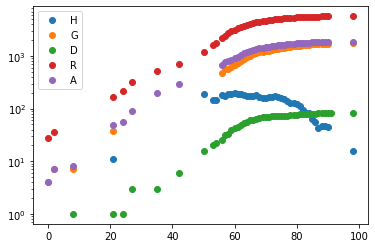

In [5]:
plt.semilogy(time, H, 'o', time, G, 'o', time, D, 'o', time, cE, 'o', time , cH, 'o')
plt.legend("HGDRA")

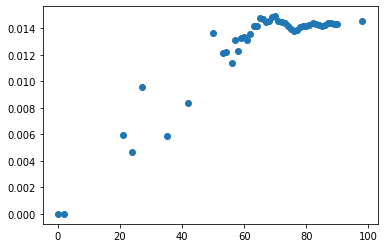

In [6]:
plt.plot(time,[d/ce if ce else None for d,ce in zip(D,cE)],'o')

In [7]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 0
data_time = time[start:]
data_pd = data_pd[start:,:]

p0 = [1.5, 1e-6, 0, 1e-6, 1e-6, 0.015]
config = {
    "grid_size": 200,
    "basis_number": 40,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.25],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy(p0),
}

In [8]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [9]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [10]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 1e2

In [11]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7343

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

(0, 3000)

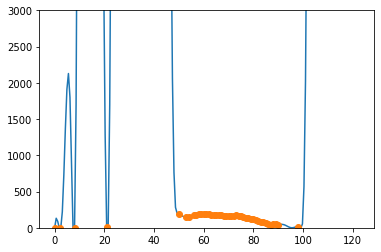

In [12]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[3])
plt.plot(time, H, 'o')
plt.ylim([0, 3000])

In [13]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7343

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

 110  8.2879412e+01 0.00e+00 2.47e+04  -3.8 3.21e+03    -  1.00e+00 1.00e+00f  1
 120  8.2879011e+01 0.00e+00 5.81e+02  -3.8 1.57e+03    -  1.00e+00 1.00e+00h  1
 130  8.2879001e+01 0.00e+00 1.61e-06  -3.8 8.80e-02    -  1.00e+00 1.00e+00h  1
 140  8.2846613e+01 0.00e+00 8.29e+03  -5.7 1.34e+04 -12.6 9.55e-01 5.00e-01f  2
 150  8.2832884e+01 0.00e+00 6.75e-02  -5.7 1.76e+01 -10.5 1.00e+00 1.00e+00h  1
 160  8.2832568e+01 0.00e+00 3.02e+00  -5.7 4.54e+03 -13.4 1.00e+00 1.00e+00f  1
 170  8.2831947e+01 0.00e+00 4.20e+02  -5.7 5.45e+04    -  5.37e-01 1.30e-01f  3
 180  8.2831828e+01 0.00e+00 2.27e-01  -5.7 4.45e+02 -12.8 1.00e+00 1.00e+00h  1
 190  8.2831735e+01 0.00e+00 1.59e-01  -5.7 2.47e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  8.2831716e+01 0.00e+00 1.12e+00  -5.7 1.46e+04    -  6.48e-01 2.00e-02h  6
 210  8.2831716e+01 0.00e+00 3.67e-01  -5.7 7.32e+01    -  1.00e+00 1.00e+00h  1
 220  8.2831716e+01 0.00e+00

 120  8.2869065e+01 0.00e+00 8.96e-03  -5.7 1.16e+03    -  1.00e+00 1.00e+00h  1
 130  8.2869160e+01 0.00e+00 1.52e-02  -5.7 1.48e+02    -  1.00e+00 1.00e+00h  1
 140  8.2869275e+01 0.00e+00 8.77e-02  -5.7 7.18e+02    -  1.00e+00 5.00e-01h  2
 150  8.2869401e+01 0.00e+00 1.32e-01  -5.7 2.32e+03    -  1.00e+00 2.50e-01h  3
 160  8.2869568e+01 0.00e+00 3.05e-01  -5.7 3.97e+03    -  1.00e+00 2.50e-01h  3
 170  8.2869663e+01 0.00e+00 2.16e-01  -5.7 3.42e+03 -13.6 1.00e+00 5.00e-01h  2
 180  8.2869751e+01 0.00e+00 6.35e-03  -5.7 1.56e+02 -12.4 1.00e+00 1.00e+00h  1
 190  8.2869802e+01 0.00e+00 6.32e-02  -5.7 7.13e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  8.2869866e+01 0.00e+00 5.22e-02  -5.7 6.25e+03    -  1.00e+00 2.50e-01h  3
 210  8.2869890e+01 0.00e+00 9.10e-04  -5.7 9.39e+01    -  1.00e+00 1.00e+00h  1
 220  8.2869664e+01 0.00e+00 7.31e-02  -8.6 1.89e+02 -12.2 1.00e+00 1.00e+00h  1
 230  8.2869618e+01 0.00e+00

 290  8.2913982e+01 0.00e+00 1.16e-01  -8.6 7.13e+01 -10.4 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  8.2913917e+01 0.00e+00 1.31e-01  -8.6 2.35e+01  -8.9 1.00e+00 1.00e+00h  1
 310  8.2913870e+01 0.00e+00 7.99e-03  -8.6 7.10e+02 -12.7 1.00e+00 1.00e+00h  1
 320  8.2913999e+01 0.00e+00 4.14e-01  -8.6 1.56e+03 -13.4 3.76e-01 3.95e-01H  1
 330  8.2913819e+01 0.00e+00 8.70e-03  -8.6 2.64e+01 -10.5 1.00e+00 1.00e+00h  1
 340  8.2913799e+01 0.00e+00 1.48e-02  -8.6 3.38e+02 -12.6 1.00e+00 1.00e+00h  1
 350  8.2913821e+01 0.00e+00 2.33e-01  -8.6 3.09e+03 -11.9 4.86e-01 7.37e-02H  1
 360  8.2913734e+01 0.00e+00 2.94e-03  -8.6 9.15e+00 -10.4 1.00e+00 1.00e+00h  1
 370  8.2913711e+01 0.00e+00 7.93e-05  -8.6 7.79e-01  -7.8 1.00e+00 1.00e+00h  1
 380  8.2913700e+01 0.00e+00 1.29e-03  -8.6 3.76e+01 -11.1 1.00e+00 1.00e+00h  1
 390  8.2913696e+01 0.00e+00 4.44e-05  -8.6 4.33e-01  -9.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 490  8.2968589e+01 0.00e+00 5.70e-08  -8.6 8.24e-01 -10.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 492

                                   (scaled)                 (unscaled)
Objective...............:   8.2968588507974147e+01    8.2968588507974147e+01
Dual infeasibility......:   1.5268284780175604e-09    1.5268284780175604e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059200999206457e-09    2.5059200999206457e-09
Overall NLP error.......:   2.5059200999206457e-09    2.5059200999206457e-09


Number of objective function evaluations             = 999
Number of objective gradient evaluations             = 493
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 999
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 49

  10  8.9844925e+01 0.00e+00 4.33e+01  -1.0 7.27e+02    -  5.58e-01 8.11e-01f  1
  20  8.4395849e+01 0.00e+00 1.38e+00  -3.8 1.41e+02  -5.9 6.90e-01 1.00e+00f  1
  30  8.4162452e+01 0.00e+00 2.69e-03  -5.7 2.48e+00  -4.3 1.00e+00 9.68e-01f  1
  40  8.3310088e+01 0.00e+00 5.95e+00  -5.7 1.94e+03  -9.1 4.12e-01 1.06e-01f  1
  50  8.3109495e+01 0.00e+00 6.17e-01  -5.7 2.90e+03 -12.1 2.85e-01 5.16e-01f  1
  60  8.3107273e+01 0.00e+00 5.29e-02  -5.7 8.51e+02 -12.7 1.00e+00 1.00e+00f  1
  70  8.3106994e+01 0.00e+00 3.78e-02  -5.7 1.10e+04    -  1.00e+00 2.50e-01f  3
  80  8.3106819e+01 0.00e+00 3.80e-02  -5.7 1.49e+04    -  1.00e+00 5.00e-01f  2
  90  8.3106644e+01 0.00e+00 2.69e-04  -5.7 1.37e+00  -8.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.3106517e+01 0.00e+00 2.15e-03  -5.7 2.74e+00  -6.3 1.00e+00 1.00e+00F  1
 110  8.3106529e+01 0.00e+00 2.75e-05  -5.7 5.44e-02  -3.3 1.00e+00 1.00e+00h  1
 120  8.3106388e+01 0.00e+00

 510  8.3188983e+01 0.00e+00 4.23e-01  -5.7 2.16e+02 -11.0 1.00e+00 1.00e+00H  1
 520  8.3188685e+01 0.00e+00 1.04e+01  -5.7 1.10e+04 -13.9 9.11e-01 2.50e-01h  3
 530  8.3188564e+01 0.00e+00 8.48e-02  -5.7 2.58e+02 -12.4 1.00e+00 1.00e+00h  1
 540  8.3188436e+01 0.00e+00 2.37e-01  -5.7 2.81e+02 -12.6 1.00e+00 1.00e+00h  1
 550  8.3188332e+01 0.00e+00 3.27e-02  -5.7 1.36e+02 -11.1 1.00e+00 1.00e+00h  1
 560  8.3188169e+01 0.00e+00 2.64e-01  -5.7 6.43e+02 -10.5 1.00e+00 4.66e-02h  5
 570  8.3187994e+01 0.00e+00 1.03e-01  -5.7 8.03e+01 -10.7 1.00e+00 1.00e+00h  1
 580  8.3187856e+01 0.00e+00 1.25e-02  -5.7 8.70e+00  -9.6 1.00e+00 1.00e+00h  1
 590r 9.2784117e+01 0.00e+00 5.27e-02  -5.7 1.21e-01    -  9.05e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  8.3187801e+01 0.00e+00 3.50e-01  -5.7 3.11e+01 -10.5 1.00e+00 1.00e+00h  1
 610  8.3187661e+01 0.00e+00 1.05e+00  -5.7 1.04e+03 -13.8 1.00e+00 1.00e+00h  1
 620  8.3187683e+01 0.00e+00

  60  8.3406572e+01 0.00e+00 4.48e+00  -3.8 9.39e+03    -  2.32e-01 7.25e-02f  4
  70  8.3388011e+01 0.00e+00 1.84e-01  -5.7 5.96e-01  -4.4 1.00e+00 1.00e+00h  1
  80  8.3383752e+01 0.00e+00 1.76e-01  -5.7 1.20e+02  -9.2 1.00e+00 7.44e-01f  1
  90  8.3382628e+01 0.00e+00 1.18e-01  -5.7 3.36e+01  -9.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.3380834e+01 0.00e+00 1.05e+00  -5.7 9.99e+02 -11.5 1.00e+00 5.00e-01f  2
 110  8.3379203e+01 0.00e+00 2.37e-01  -5.7 1.41e+02 -10.0 1.00e+00 1.00e+00f  1
 120  8.3377786e+01 0.00e+00 8.92e-01  -5.7 5.19e+02 -10.2 1.00e+00 2.50e-01f  3
 130  8.3376630e+01 0.00e+00 5.96e-01  -5.7 8.49e+02 -12.3 1.00e+00 1.00e+00f  1
 140  8.3375525e+01 0.00e+00 3.00e-01  -5.7 4.04e+03 -12.5 1.00e+00 2.50e-01f  3
 150  8.3374503e+01 0.00e+00 7.22e-02  -5.7 1.52e+02 -10.1 1.00e+00 1.00e+00f  1
 160  8.3373667e+01 0.00e+00 1.16e-02  -5.7 1.05e+03 -12.1 1.00e+00 1.00e+00f  1
 170  8.3373012e+01 0.00e+00

  20  8.3571000e+01 0.00e+00 5.19e+00  -5.7 2.96e+01  -6.3 5.30e-02 4.60e-02f  1
  30  8.3565513e+01 0.00e+00 7.59e-01  -5.7 9.82e+02    -  1.00e+00 1.00e+00h  1
  40  8.3565417e+01 0.00e+00 6.49e-04  -5.7 9.15e+00    -  1.00e+00 1.00e+00h  1
  50  8.3565173e+01 0.00e+00 1.40e-04  -8.6 8.67e-01  -6.5 9.66e-01 5.30e-01f  1
  60  8.3565132e+01 0.00e+00 1.31e-04  -8.6 3.11e+03    -  1.00e+00 9.51e-02f  1

Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:   8.3565129760689658e+01    8.3565129760689658e+01
Dual infeasibility......:   8.3899901893581340e-10    8.3899901893581340e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.1789137947395789e-09    3.1789137947395789e-09
Overall NLP error.......:   3.1789137947395789e-09    3.1789137947395789e-09


Number of objective function evaluations             = 75
Number of objective gradient evaluations        

  30  8.3937298e+01 0.00e+00 5.61e-01  -3.8 1.07e+02  -8.5 1.00e+00 1.00e+00f  1
  40  8.3957693e+01 0.00e+00 6.46e+00  -3.8 2.26e+02  -8.6 1.00e+00 5.00e-01f  2
  50  8.3969137e+01 0.00e+00 6.50e+00  -3.8 1.74e+01  -7.5 1.00e+00 1.00e+00f  1
  60  8.3959581e+01 0.00e+00 8.00e-01  -5.7 4.07e+01  -7.3 3.50e-01 6.05e-01f  1
  70  8.3942090e+01 0.00e+00 2.26e-05  -5.7 4.73e-03  -2.8 1.00e+00 1.00e+00h  1
  80  8.3941863e+01 0.00e+00 2.82e-02  -5.7 9.85e+00  -7.6 1.00e+00 1.00e+00f  1
  90  8.3936033e+01 0.00e+00 5.59e-05  -5.7 6.04e-03  -2.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.3935519e+01 0.00e+00 3.61e-03  -5.7 4.43e+00  -6.8 1.00e+00 1.00e+00h  1
 110  8.3930132e+01 0.00e+00 7.93e+00  -5.7 5.05e+03 -11.6 5.52e-01 5.83e-01f  1
 120  8.3917400e+01 0.00e+00 3.05e+00  -5.7 4.68e+03 -11.8 2.97e-01 1.08e-01f  1
 130  8.3900950e+01 0.00e+00 4.32e-04  -5.7 2.30e+00  -5.6 1.00e+00 1.00e+00f  1
 140  8.3895331e+01 0.00e+00

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.5402059e+01 0.00e+00 1.97e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  8.5803473e+01 0.00e+00 4.49e-02  -2.5 5.12e-01  -1.1 1.00e+00 1.00e+00f  1
  20  8.4613226e+01 0.00e+00 2.82e+00  -3.8 4.42e+04    -  1.65e-01 1.16e-01f  2
  30  8.4345388e+01 0.00e+00 3.01e-03  -3.8 4.37e-01  -6.4 1.00e+00 1.00e+00h  1
  40  8.4347915e+0

 420  8.4485715e+01 0.00e+00 9.37e+00  -5.7 5.11e+01    -  1.00e+00 1.00e+00h  1
 430  8.4485715e+01 0.00e+00 1.88e+02  -5.7 4.54e+02    -  1.00e+00 5.00e-01h  2
 440  8.4485715e+01 0.00e+00 4.53e+01  -5.7 9.64e+03    -  7.35e-01 1.12e-02h  7
 450  8.4485715e+01 0.00e+00 1.00e+02  -5.7 2.32e+03    -  1.00e+00 6.25e-02h  5
 460  8.4485715e+01 0.00e+00 6.68e+01  -5.7 2.17e+02    -  1.00e+00 5.00e-01h  2
 470  8.4485715e+01 0.00e+00 3.28e+01  -5.7 1.37e+02    -  1.00e+00 5.00e-01h  2
 480  8.4485715e+01 0.00e+00 2.06e+01  -5.7 5.44e+01    -  1.00e+00 1.00e+00h  1
 490  8.4485715e+01 0.00e+00 3.41e+01  -5.7 1.27e+02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  8.4485715e+01 0.00e+00 1.70e+01  -5.7 4.40e+01    -  1.00e+00 1.00e+00h  1
 510  8.4485715e+01 0.00e+00 3.08e+01  -5.7 5.61e+01    -  1.00e+00 1.00e+00h  1
 520  8.4485715e+01 0.00e+00 1.10e+01  -5.7 4.77e+02    -  1.00e+00 6.25e-02h  5
 530  8.4485715e+01 0.00e+00

  10  8.5496383e+01 0.00e+00 9.46e-03  -2.5 8.32e-01  -2.0 1.00e+00 1.00e+00f  1
  20  8.4992354e+01 0.00e+00 3.97e-03  -5.7 4.22e-01  -2.2 1.00e+00 1.00e+00f  1
  30  8.4977136e+01 0.00e+00 3.48e-01  -5.7 4.21e+00  -6.0 8.70e-01 1.00e+00f  1
  40  8.4963681e+01 0.00e+00 1.64e+00  -5.7 4.86e+01    -  1.00e+00 1.00e+00f  1
  50  8.4963377e+01 0.00e+00 6.60e-03  -5.7 1.30e+01    -  1.00e+00 1.00e+00h  1
  60  8.4963147e+01 0.00e+00 1.04e-06  -8.6 8.96e-01  -9.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 65

                                   (scaled)                 (unscaled)
Objective...............:   8.4963146954549757e+01    8.4963146954549757e+01
Dual infeasibility......:   3.4269875581955599e-09    3.4269875581955599e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   3.4269875581955599e-09    3.4269875581955599e-09


Number of objective funct

  60  8.7763354e+01 0.00e+00 1.88e+01  -3.8 1.87e+03 -11.4 1.00e+00 2.50e-01f  3
  70  8.7699873e+01 0.00e+00 1.18e+01  -3.8 2.09e+03 -10.7 1.00e+00 1.04e-01f  4
  80  8.7581445e+01 0.00e+00 3.45e+01  -3.8 2.12e+01  -7.4 1.00e+00 1.25e-01f  4
  90  8.7562383e+01 0.00e+00 1.11e+02  -3.8 1.91e+01  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.7535179e+01 0.00e+00 1.54e+00  -3.8 2.82e+01  -7.9 1.00e+00 1.00e+00f  1
 110  8.7514526e+01 0.00e+00 3.69e+00  -3.8 2.18e+02  -9.1 1.00e+00 1.00e+00f  1
 120  8.7489959e+01 0.00e+00 2.98e+01  -3.8 6.81e+01  -8.4 1.00e+00 1.00e+00f  1
 130  8.7421815e+01 0.00e+00 4.63e-03  -3.8 1.57e+00  -6.0 1.00e+00 1.00e+00f  1
 140  8.7366731e+01 0.00e+00 1.98e-02  -3.8 3.52e+00  -6.2 1.00e+00 1.00e+00f  1
 150  8.7347311e+01 0.00e+00 3.88e+00  -3.8 1.48e+01  -7.4 1.00e+00 1.00e+00f  1
 160  8.7261113e+01 0.00e+00 1.94e+01  -3.8 3.57e+01  -7.6 1.00e+00 1.00e+00f  1
 170  8.7182206e+01 0.00e+00

 410  8.7148549e+01 0.00e+00 5.84e+03  -5.7 5.51e+02 -13.2 5.51e-02 1.31e-01f  1
 420  8.7003065e+01 0.00e+00 9.51e+03  -5.7 1.88e+03    -  3.46e-01 3.15e-01f  1
 430  8.6899500e+01 0.00e+00 2.89e+03  -5.7 1.78e+02    -  2.86e-01 1.59e-01f  1
 440  8.6830726e+01 0.00e+00 4.93e+03  -5.7 1.05e+03    -  1.86e-01 6.90e-01f  1
 450  8.6795325e+01 0.00e+00 4.38e+03  -5.7 1.48e+03    -  5.92e-01 7.33e-01f  1
 460  8.6790706e+01 0.00e+00 9.80e+00  -5.7 1.80e+01 -10.6 1.00e+00 1.00e+00f  1
 470  8.6790274e+01 0.00e+00 1.28e+04  -5.7 4.24e+04    -  3.70e-01 9.33e-02f  3
 480  8.6790044e+01 0.00e+00 4.62e+04  -5.7 9.29e+04    -  1.00e+00 5.15e-02h  5
 490  8.6789987e+01 0.00e+00 9.05e+02  -5.7 9.29e+03    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  8.6789987e+01 0.00e+00 1.02e+03  -5.7 4.36e+03    -  1.00e+00 1.25e-01h  4
 510  8.6789987e+01 0.00e+00 4.35e+02  -5.7 1.10e+04    -  1.00e+00 3.12e-02h  6
 520  8.6789987e+01 0.00e+00

  30  1.0917892e+02 0.00e+00 2.54e+00  -1.7 7.77e+00  -3.9 1.00e+00 1.00e+00f  1
  40  9.0577298e+01 0.00e+00 1.93e+01  -2.5 8.20e+02  -8.7 1.00e+00 1.00e+00f  1
  50  9.0638288e+01 0.00e+00 4.21e+01  -2.5 1.13e+03  -9.8 5.69e-01 1.00e+00f  1
  60  9.0759199e+01 0.00e+00 1.76e+02  -2.5 2.18e+04    -  5.41e-01 9.64e-02f  4
  70  9.0700915e+01 0.00e+00 6.53e-01  -2.5 1.05e+02  -8.8 1.00e+00 1.00e+00f  1
  80  9.0753103e+01 0.00e+00 1.05e+01  -2.5 1.45e+03 -10.7 1.00e+00 1.00e+00f  1
  90  9.0794411e+01 0.00e+00 3.65e+01  -2.5 1.13e+03 -11.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.0811540e+01 0.00e+00 2.32e+01  -2.5 2.00e+03    -  1.00e+00 5.00e-01f  2
 110  9.0407618e+01 0.00e+00 1.09e+02  -3.8 2.11e+03 -11.1 1.00e+00 1.00e+00f  1
 120  9.0352055e+01 0.00e+00 6.85e+01  -3.8 1.20e+03 -11.8 1.00e+00 1.00e+00f  1
 130  9.0316811e+01 0.00e+00 6.55e+01  -3.8 2.62e+03 -12.0 1.00e+00 5.00e-01f  2
 140  9.0295607e+01 0.00e+00

 960  8.7454067e+01 0.00e+00 1.94e+02  -5.7 3.59e+01    -  1.00e+00 1.00e+00h  1
 970  8.7454067e+01 0.00e+00 4.81e+01  -5.7 1.60e+01    -  1.00e+00 1.00e+00h  1
 980  8.7454065e+01 0.00e+00 7.98e-01  -5.7 5.78e-01    -  1.00e+00 1.00e+00h  1
 990  8.7454066e+01 0.00e+00 5.27e+02  -5.7 9.15e+01    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  8.7454062e+01 0.00e+00 6.38e+01  -5.7 1.39e+01    -  1.00e+00 1.00e+00h  1
1010  8.7454061e+01 0.00e+00 2.89e+02  -5.7 5.45e+01    -  1.00e+00 5.00e-01h  2
1020  8.7454057e+01 0.00e+00 9.41e+01  -5.7 2.16e+02    -  1.00e+00 6.25e-02h  5
1030  8.7454055e+01 0.00e+00 2.39e+02  -5.7 3.92e+01    -  1.00e+00 5.00e-01h  2
1040  8.7454048e+01 0.00e+00 1.43e+02  -5.7 5.25e+01    -  1.00e+00 2.50e-01h  3
1050  8.7454039e+01 0.00e+00 2.47e+01  -5.7 4.53e+00    -  1.00e+00 1.00e+00h  1
1060  8.7454026e+01 0.00e+00 1.38e+01  -5.7 2.75e+00    -  1.00e+00 1.00e+00h  1
1070  8.7454006e+01 0.00e+00

 480  9.1549109e+01 0.00e+00 4.60e+04  -3.8 2.12e+02    -  1.00e+00 1.00e+00h  1
 490  9.1549108e+01 0.00e+00 2.72e+04  -3.8 2.80e+03    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  9.1549108e+01 0.00e+00 3.45e+04  -3.8 2.35e+02    -  1.00e+00 1.00e+00h  1
 510  9.1549108e+01 0.00e+00 1.89e+04  -3.8 2.06e+02    -  1.00e+00 1.00e+00h  1
 520  9.1549109e+01 0.00e+00 1.01e+05  -3.8 5.15e+02    -  1.00e+00 1.00e+00h  1
 530  9.1549108e+01 0.00e+00 5.52e+02  -3.8 1.41e+02    -  1.00e+00 1.00e+00h  1
 540  9.1549115e+01 0.00e+00 5.49e+05  -3.8 3.03e+03    -  1.00e+00 5.00e-01h  2
 550  9.1549108e+01 0.00e+00 2.06e+04  -3.8 4.13e+02    -  1.00e+00 1.00e+00h  1
 560  9.1549108e+01 0.00e+00 1.44e+05  -3.8 1.64e+04    -  1.00e+00 6.25e-02h  5
 570  9.1549108e+01 0.00e+00 1.88e+05  -3.8 1.36e+03    -  1.00e+00 1.00e+00h  1
 580  9.1549107e+01 0.00e+00 1.50e+05  -3.8 5.04e+03    -  1.00e+00 2.50e-01h  3
 590  9.1549107e+01 0.00e+00

  30  9.0296270e+01 0.00e+00 4.12e+00  -2.5 3.89e+02    -  1.00e+00 1.25e-01f  4
  40  9.0303531e+01 0.00e+00 2.56e+00  -2.5 1.31e+01    -  1.00e+00 1.00e+00f  1
  50  9.0306642e+01 0.00e+00 9.00e+00  -2.5 1.07e+01    -  1.00e+00 1.00e+00h  1
  60  9.0308289e+01 0.00e+00 1.64e+01  -2.5 2.58e+01    -  1.00e+00 2.50e-01h  3
  70  9.0309354e+01 0.00e+00 6.30e+01  -2.5 1.34e+01    -  1.00e+00 5.00e-01h  2
  80  9.0309983e+01 0.00e+00 2.70e-04  -2.5 5.89e-04  -2.0 1.00e+00 1.00e+00h  1
  90  8.9369545e+01 0.00e+00 4.00e+02  -3.8 3.32e+00  -4.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.9216375e+01 0.00e+00 1.52e+01  -3.8 7.07e+03    -  1.00e+00 8.40e-01f  1
 110  8.9204415e+01 0.00e+00 2.12e+01  -3.8 3.81e+01    -  1.00e+00 5.00e-01f  2
 120  8.9195621e+01 0.00e+00 1.26e+01  -3.8 1.45e+02    -  1.00e+00 1.00e+00f  1
 130  8.9151868e+01 0.00e+00 4.87e+00  -3.8 2.74e+02    -  1.00e+00 1.00e+00f  1
 140  8.9126056e+01 0.00e+00

                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.3984125e+01 0.00e+00 2.15e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.1455267e+02 0.00e+00 1.65e+02  -1.0 6.54e+04    -  7.98e-03 7.34e-03f  2
  20  9.5044740e+01 0.00e+00 1.23e+00  -2.5 7.27e+01  -6.4 1.00e+00 1.00e+00f  1
  30  9.3581895e+01 0.00e+00 2.60e+01  -3.8 1.05e+03    -  6.57e-01 3.03e-01f  2
  40  9.3046046e+01 0.00e+00 2.76e-02  -3.8 7.64e+00  -7.5 1.00e+00 1.00e+00f  1
 

  10  1.3099385e+02 0.00e+00 2.06e+02  -1.0 9.61e+02    -  7.98e-01 5.00e-01f  2
  20  1.4875670e+02 0.00e+00 5.26e+01  -1.0 2.20e+02  -6.4 1.00e+00 1.00e+00f  1
  30  1.5801230e+02 0.00e+00 3.40e+03  -1.0 1.94e+03  -7.9 1.00e+00 1.00e+00f  1
  40  1.5796791e+02 0.00e+00 5.10e+02  -1.0 4.43e+02  -7.6 1.00e+00 1.00e+00f  1
  50  1.5880557e+02 0.00e+00 4.91e+02  -1.0 1.48e+03  -8.7 1.00e+00 1.00e+00f  1
  60  1.6066219e+02 0.00e+00 2.10e+02  -1.0 2.97e+03 -10.2 1.00e+00 1.00e+00f  1
  70  1.4779485e+02 0.00e+00 1.75e+03  -1.7 2.78e+03 -10.3 1.00e+00 1.00e+00f  1
  80  1.4542830e+02 0.00e+00 1.34e+03  -1.7 1.99e+03    -  1.00e+00 1.00e+00f  1
  90  1.4496671e+02 0.00e+00 1.08e+00  -1.7 4.53e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4175674e+02 0.00e+00 1.52e+03  -3.8 2.70e+03 -10.6 1.00e+00 5.00e-01f  2
 110  1.4115611e+02 0.00e+00 8.80e+02  -3.8 1.49e+04 -10.9 2.53e-01 3.21e-02f  4
 120  1.4087405e+02 0.00e+00

 140  1.5717860e+02 0.00e+00 3.63e+03  -3.8 1.20e+03 -10.2 1.00e+00 2.50e-01f  3
 150  1.5702160e+02 0.00e+00 3.53e+01  -3.8 3.61e+02  -9.5 1.00e+00 1.00e+00f  1
 160  1.5691306e+02 0.00e+00 1.87e+01  -3.8 2.16e-01  -5.3 1.00e+00 1.00e+00h  1
 170  1.5684834e+02 0.00e+00 3.50e+04  -3.8 1.71e+03 -10.1 1.00e+00 1.00e+00f  1
 180  1.5666549e+02 0.00e+00 2.20e+02  -3.8 5.22e+02  -9.4 1.00e+00 1.00e+00f  1
 190  1.5626209e+02 0.00e+00 7.61e+02  -3.8 6.43e-01  -4.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.5622605e+02 0.00e+00 7.17e+01  -3.8 3.97e+02  -9.0 1.00e+00 1.00e+00f  1
 210  1.5591599e+02 0.00e+00 8.61e+03  -3.8 6.20e+00  -5.7 1.00e+00 5.00e-01f  2
 220  1.5583746e+02 0.00e+00 3.28e+04  -3.8 1.36e+01  -6.8 1.00e+00 5.00e-01f  2
 230  1.5565768e+02 0.00e+00 7.98e+03  -3.8 8.44e+00  -7.1 1.00e+00 1.00e+00f  1
 240  1.5521665e+02 0.00e+00 8.58e+02  -3.8 1.73e+02  -8.2 1.00e+00 1.00e+00f  1
 250  1.5505996e+02 0.00e+00

  60  2.2600637e+02 0.00e+00 2.73e+03  -1.0 1.04e+04  -8.9 1.00e+00 5.00e-01f  2
  70  2.2652369e+02 0.00e+00 8.45e+01  -1.0 8.15e+02  -9.1 1.00e+00 1.00e+00f  1
  80  2.2764081e+02 0.00e+00 1.39e+00  -1.0 3.51e+01    -  1.00e+00 1.00e+00h  1
  90  2.1021962e+02 0.00e+00 3.53e+03  -2.5 2.31e+03 -10.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0834728e+02 0.00e+00 3.12e+02  -2.5 5.87e+02  -9.6 1.00e+00 1.00e+00f  1
 110  2.0714859e+02 0.00e+00 4.64e+03  -2.5 5.93e+03 -10.8 1.00e+00 1.00e+00f  1
 120  2.0658812e+02 0.00e+00 1.87e+03  -2.5 8.29e+03 -11.0 1.00e+00 2.50e-01f  3
 130  2.0618416e+02 0.00e+00 3.34e+02  -2.5 1.04e+03  -9.9 1.00e+00 1.00e+00f  1
 140  2.0533549e+02 0.00e+00 2.54e+03  -2.5 7.77e+03  -8.8 1.00e+00 1.05e-01f  3
 150  2.0409366e+02 0.00e+00 3.47e+03  -2.5 8.98e+01  -8.1 1.00e+00 1.00e+00f  1
 160  2.0113525e+02 0.00e+00 5.94e+04  -2.5 2.12e+04    -  4.42e-01 1.39e-01f  3
 170  1.9924684e+02 0.00e+00

  30  1.8056863e+02 0.00e+00 3.31e+01  -1.0 1.90e+03    -  1.00e+00 5.00e-01f  2
  40  1.8897498e+02 0.00e+00 3.54e+01  -1.0 3.22e+03    -  1.00e+00 1.00e+00f  1
  50  1.6252863e+02 0.00e+00 6.55e+01  -2.5 1.31e+04    -  8.98e-01 1.00e+00f  1
  60  1.5607647e+02 0.00e+00 2.71e+01  -3.8 3.88e+03  -9.9 1.00e+00 1.00e+00f  1
  70  1.4677309e+02 0.00e+00 5.40e+01  -3.8 1.66e+03  -8.3 1.00e+00 1.00e+00f  1
  80  1.2931325e+02 0.00e+00 9.30e-01  -3.8 5.74e+01  -5.9 1.00e+00 1.00e+00f  1
  90  1.2575917e+02 0.00e+00 1.62e+01  -3.8 1.65e+04    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2570123e+02 0.00e+00 7.77e+00  -5.7 2.12e+04    -  1.00e+00 8.03e-01f  1
 110  1.2569615e+02 0.00e+00 1.46e-02  -8.6 3.31e+03    -  9.67e-01 7.45e-01f  1

Number of Iterations....: 117

                                   (scaled)                 (unscaled)
Objective...............:   1.2569610494162627e+02    1.2569610494162627e+02
Dual infea

  30  1.6005544e+02 0.00e+00 2.22e+01  -1.7 3.99e+01  -5.5 1.00e+00 1.00e+00f  1
  40  1.5577130e+02 0.00e+00 1.33e+00  -1.7 6.21e+02    -  1.00e+00 1.00e+00f  1
  50  1.5171297e+02 0.00e+00 1.74e+00  -3.8 1.88e+04    -  1.00e+00 1.25e-01f  4
  60  1.5169891e+02 0.00e+00 3.78e-06  -5.7 1.72e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:   1.5169871038971263e+02    1.5169871038971263e+02
Dual infeasibility......:   9.9539019527882558e-10    9.9539019527882558e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.3484296284736255e-09    3.3484296284736255e-09
Overall NLP error.......:   3.3484296284736255e-09    3.3484296284736255e-09


Number of objective function evaluations             = 92
Number of objective gradient evaluations             = 65
Number of equality constraint evaluations            = 0
Number of ineq

  40  1.9927298e+02 0.00e+00 2.52e+02  -3.8 6.83e+02    -  7.36e-01 2.23e-01f  3
  50  1.9679669e+02 0.00e+00 1.30e-02  -3.8 8.33e+01    -  1.00e+00 1.00e+00h  1
  60  1.9678075e+02 0.00e+00 1.22e-03  -8.6 5.43e+02    -  9.96e-01 7.48e-01f  1

Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:   1.9678075389619238e+02    1.9678075389619238e+02
Dual infeasibility......:   1.0659523253901111e-10    1.0659523253901111e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.4792605071286512e-10    9.4792605071286512e-10
Overall NLP error.......:   9.4792605071286512e-10    9.4792605071286512e-10


Number of objective function evaluations             = 92
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 92
Number of equality constraint Jacobia

  20  2.9629262e+02 0.00e+00 1.14e+02  -1.0 3.42e+03    -  1.00e+00 1.00e+00f  1
  30  2.8271981e+02 0.00e+00 4.60e+02  -2.5 1.24e+02  -5.5 9.45e-01 5.00e-01f  2
  40  2.7888946e+02 0.00e+00 2.09e+00  -5.7 5.83e+03    -  1.00e+00 9.42e-01f  1

Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:   2.7888935544803826e+02    2.7888935544803826e+02
Dual infeasibility......:   3.7621835708220756e-10    3.7621835708220756e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.4081452578413813e-09    1.4081452578413813e-09
Overall NLP error.......:   1.4081452578413813e-09    1.4081452578413813e-09


Number of objective function evaluations             = 67
Number of objective gradient evaluations             = 48
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 67
Number of equality constraint Jacobia


Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:   4.1649199162685272e+02    4.1649199162685272e+02
Dual infeasibility......:   4.0922776802304913e-11    4.0922776802304913e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.4491456734152660e-09    3.4491456734152660e-09
Overall NLP error.......:   3.4491456734152660e-09    3.4491456734152660e-09


Number of objective function evaluations             = 44
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 44
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian Hessian evaluations             = 35
Total CPU secs in IPOPT (w/o function evaluations)   =      0.201
Total CPU secs in NLP function evaluation

  30  6.3352188e+02 0.00e+00 4.25e-07  -8.6 1.48e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 31

                                   (scaled)                 (unscaled)
Objective...............:   6.3352187545749223e+02    6.3352187545749223e+02
Dual infeasibility......:   1.7932078386688192e-10    1.7932078386688192e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5137106199536637e-09    2.5137106199536637e-09
Overall NLP error.......:   2.5137106199536637e-09    2.5137106199536637e-09


Number of objective function evaluations             = 33
Number of objective gradient evaluations             = 32
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 33
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 32
Number of Lagrangian Hessian evaluations             = 31
Total CPU secs in IPOPT (w

  20  9.4526818e+02 0.00e+00 6.70e+01  -2.5 8.24e+02    -  9.31e-01 1.00e+00f  1
  30  9.4277274e+02 0.00e+00 1.88e+00  -3.8 1.43e+03    -  1.00e+00 1.00e+00f  1
  40  9.4274666e+02 0.00e+00 3.35e-10  -8.6 1.39e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:   9.4274665756477646e+02    9.4274665756477646e+02
Dual infeasibility......:   3.3532685566065930e-10    3.3532685566065930e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5545072681092795e-09    2.5545072681092795e-09
Overall NLP error.......:   2.5545072681092795e-09    2.5545072681092795e-09


Number of objective function evaluations             = 46
Number of objective gradient evaluations             = 41
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 46
Number of equality constraint Jacobia

  30  1.3371881e+03 0.00e+00 1.10e-01  -5.7 5.10e+02    -  1.00e+00 6.68e-01f  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   1.3371878942276578e+03    1.3371878942276578e+03
Dual infeasibility......:   3.0702789569040191e-10    3.0702789569040191e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6877882272949693e-09    2.6877882272949693e-09
Overall NLP error.......:   2.6877882272949693e-09    2.6877882272949693e-09


Number of objective function evaluations             = 42
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 42
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 38
Number of Lagrangian Hessian evaluations             = 37
Total CPU secs in IPOPT (w

  20  1.8117877e+03 0.00e+00 1.36e+02  -1.0 2.37e+03    -  1.00e+00 1.00e+00f  1
  30  1.8017845e+03 0.00e+00 3.63e+01  -3.8 1.47e+04    -  1.00e+00 1.00e+00f  1
  40  1.8017341e+03 0.00e+00 5.89e-07  -5.7 2.99e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 44

                                   (scaled)                 (unscaled)
Objective...............:   1.8017339711725037e+03    1.8017339711725037e+03
Dual infeasibility......:   7.3519521496935419e-10    7.3519521496935419e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.5670199329455092e-09    7.5670199329455092e-09
Overall NLP error.......:   7.5670199329455092e-09    7.5670199329455092e-09


Number of objective function evaluations             = 58
Number of objective gradient evaluations             = 45
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 58
Number of equality constraint Jacobia

  40  2.3415013e+03 0.00e+00 1.03e-06  -5.7 2.78e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 44

                                   (scaled)                 (unscaled)
Objective...............:   2.3415012246982415e+03    2.3415012246982415e+03
Dual infeasibility......:   1.2204927655379644e-09    1.2204927655379644e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.3907050932114822e-09    2.3907050932114822e-09
Overall NLP error.......:   2.3907050932114822e-09    2.3907050932114822e-09


Number of objective function evaluations             = 67
Number of objective gradient evaluations             = 45
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 67
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 46
Number of Lagrangian Hessian evaluations             = 44
Total CPU secs in IPOPT (w


Number of Iterations....: 45

                                   (scaled)                 (unscaled)
Objective...............:   2.9648881405203947e+03    2.9648881405203947e+03
Dual infeasibility......:   3.9269872801580881e-10    3.9269872801580881e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.5927147862191945e-09    3.5927147862191945e-09
Overall NLP error.......:   3.5927147862191945e-09    3.5927147862191945e-09


Number of objective function evaluations             = 54
Number of objective gradient evaluations             = 46
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 54
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 46
Number of Lagrangian Hessian evaluations             = 45
Total CPU secs in IPOPT (w/o function evaluations)   =      0.288
Total CPU secs in NLP function evaluation

  40  3.6176696e+03 0.00e+00 4.51e+01  -3.8 2.50e+04    -  1.00e+00 3.09e-01f  2
  50  3.6176351e+03 0.00e+00 3.17e-05  -8.6 2.70e+01    -  1.00e+00 7.78e-01f  1

Number of Iterations....: 53

                                   (scaled)                 (unscaled)
Objective...............:   3.6176351313190776e+03    3.6176351313190776e+03
Dual infeasibility......:   1.6981790225541577e-09    1.6981790225541577e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.3104523825898013e-10    9.3104523825898013e-10
Overall NLP error.......:   1.6981790225541577e-09    1.6981790225541577e-09


Number of objective function evaluations             = 73
Number of objective gradient evaluations             = 54
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 73
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 54
Num

  20  4.1535933e+03 0.00e+00 8.12e+03  -1.0 2.11e+03    -  7.74e-01 2.50e-01f  3
  30  4.1475391e+03 0.00e+00 4.31e+00  -1.7 3.45e-01  -2.2 1.00e+00 1.00e+00f  1
  40  4.1464688e+03 0.00e+00 7.12e-03  -3.8 4.48e-03  -4.5 1.00e+00 1.00e+00f  1
  50  4.1464110e+03 0.00e+00 1.10e-05  -5.7 3.25e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 55

                                   (scaled)                 (unscaled)
Objective...............:   4.1464109485045647e+03    4.1464109485045647e+03
Dual infeasibility......:   2.7688166887940293e-09    2.7688166887940293e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909226524391661e-10    9.0909226524391661e-10
Overall NLP error.......:   2.7688166887940293e-09    2.7688166887940293e-09


Number of objective function evaluations             = 92
Number of objective gradient evaluations             = 56
Number of equality constraint evaluations            = 0
Number of ineq

 270  4.0865554e+03 0.00e+00 7.24e+02  -1.0 4.35e-01  -2.0 1.00e+00 1.00e+00f  1
 280  4.0670970e+03 0.00e+00 3.64e+03  -1.0 1.48e+01  -4.1 1.00e+00 1.00e+00f  1
 290  4.0388817e+03 0.00e+00 1.60e+05  -1.0 1.69e+02  -5.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.9898906e+03 0.00e+00 3.01e+04  -1.0 3.56e+01  -4.6 1.00e+00 1.00e+00f  1
 310  3.9550032e+03 0.00e+00 4.82e+03  -1.0 1.35e+01  -3.9 1.00e+00 1.00e+00f  1
 320  3.9336924e+03 0.00e+00 7.05e+02  -1.7 8.23e+00  -3.7 1.00e+00 1.00e+00f  1
 330  3.8623356e+03 0.00e+00 6.76e+04  -1.7 4.79e+04    -  6.53e-01 1.81e-02f  6
 340  3.8127965e+03 0.00e+00 8.17e+04  -1.7 1.06e+04    -  1.00e+00 6.25e-02f  5
 350  3.7927498e+03 0.00e+00 1.43e+04  -1.7 1.84e+01  -4.2 1.00e+00 1.00e+00f  1
 360  3.7778688e+03 0.00e+00 2.04e+04  -1.7 3.30e+03    -  1.00e+00 2.50e-01f  3
 370  3.7747903e+03 0.00e+00 5.11e+02  -1.7 4.95e+02    -  1.00e+00 1.00e+00f  1
 380  3.7744991e+03 0.00e+00

 180  3.8149888e+03 0.00e+00 1.74e+02  -8.6 1.01e+03  -9.9 1.00e+00 1.25e-01f  4
 190  3.8149826e+03 0.00e+00 1.40e+02  -8.6 5.12e+01  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.8149749e+03 0.00e+00 1.29e+02  -8.6 7.82e+01  -9.5 1.00e+00 1.00e+00f  1
 210  3.8149681e+03 0.00e+00 6.48e+01  -8.6 2.48e+01  -8.9 1.00e+00 1.00e+00f  1
 220  3.8149614e+03 0.00e+00 3.29e+02  -8.6 2.27e+03 -10.0 1.00e+00 6.25e-02f  5
 230  3.8149526e+03 0.00e+00 5.57e+02  -8.6 8.52e+02 -10.3 1.00e+00 2.50e-01f  3
 240  3.8149455e+03 0.00e+00 1.79e+02  -8.6 3.38e+01  -8.8 1.00e+00 1.00e+00f  1
 250  3.8149385e+03 0.00e+00 2.00e+03  -8.6 3.51e+02  -9.9 1.00e+00 1.00e+00f  1
 260  3.8149264e+03 0.00e+00 1.69e+01  -8.6 8.17e+01  -9.3 1.00e+00 1.00e+00f  1
 270  3.8149066e+03 0.00e+00 1.43e+03  -8.6 7.83e+01  -8.6 1.00e+00 1.00e+00f  1
 280  3.8148943e+03 0.00e+00 1.83e+02  -8.6 4.09e+01  -8.9 1.00e+00 1.00e+00f  1
 290  3.8148817e+03 0.00e+00

 460  3.8519222e+03 0.00e+00 4.90e+00  -8.6 5.54e+00  -7.2 1.00e+00 1.00e+00f  1
 470  3.8518958e+03 0.00e+00 4.60e-02  -8.6 1.13e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 475

                                   (scaled)                 (unscaled)
Objective...............:   3.8518957648836613e+03    3.8518957648836613e+03
Dual infeasibility......:   7.5516682711874601e-09    7.5516682711874601e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   7.5516682711874601e-09    7.5516682711874601e-09


Number of objective function evaluations             = 869
Number of objective gradient evaluations             = 476
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 869
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 47

  20  3.9242328e+03 0.00e+00 1.39e+02  -2.5 1.11e-01  -4.0 1.00e+00 1.00e+00f  1
  30  3.9243381e+03 0.00e+00 1.64e+04  -2.5 2.09e+03    -  8.21e-01 2.50e-01f  3
  40  3.9243162e+03 0.00e+00 9.10e+03  -2.5 4.61e+03    -  8.49e-01 1.25e-01f  4
  50  3.9243590e+03 0.00e+00 1.08e+04  -2.5 8.14e+03    -  9.35e-01 1.25e-01f  4
  60  3.9243678e+03 0.00e+00 8.05e+03  -2.5 1.24e+04    -  1.00e+00 1.25e-01f  4
  70  3.9243565e+03 0.00e+00 8.57e+00  -2.5 2.52e-01  -5.1 1.00e+00 1.00e+00f  1
  80  3.9243544e+03 0.00e+00 2.45e-04  -5.7 2.90e-03  -5.7 1.00e+00 1.00e+00h  1
  90  3.9243541e+03 0.00e+00 2.50e+01  -8.6 1.69e+02 -10.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.9243524e+03 0.00e+00 3.46e+02  -8.6 1.91e+02  -9.9 1.00e+00 5.00e-01f  2
 110  3.9243510e+03 0.00e+00 1.62e+01  -8.6 8.15e+01 -10.1 1.00e+00 1.00e+00f  1
 120  3.9243493e+03 0.00e+00 7.93e+01  -8.6 1.61e+02 -10.4 1.00e+00 1.00e+00f  1
 130  3.9243474e+03 0.00e+00

 150  3.9630653e+03 0.00e+00 9.86e-08  -8.6 8.30e-09    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 152

                                   (scaled)                 (unscaled)
Objective...............:   3.9630652551127992e+03    3.9630652551127992e+03
Dual infeasibility......:   5.2231048971082814e-07    5.2231048971082814e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596929637e-09    2.5059035596929637e-09
Overall NLP error.......:   5.2231048971082814e-07    5.2231048971082814e-07


Number of objective function evaluations             = 351
Number of objective gradient evaluations             = 153
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 351
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 153
Number of Lagrangian Hessian evaluations             = 152
Total CPU secs in IP

  nlp_grad_f  |  20.01ms (177.04us)  19.97ms (176.77us)       113
  nlp_hess_l  | 150.74ms (  1.32ms) 150.66ms (  1.32ms)       114
   nlp_jac_g  |   6.08ms ( 51.50us)   6.09ms ( 51.62us)       118
       total  |   1.08 s (  1.08 s)   1.08 s (  1.08 s)         1
Solving for p=20092.33002565046
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7343

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints..........

 800  4.3052314e+05 0.00e+00 1.99e+04  -1.0 5.70e-01    -  1.00e+00 5.00e-01h  2
 810  4.3052311e+05 0.00e+00 1.70e+04  -1.0 4.00e+00    -  1.00e+00 6.25e-02h  5
 820  4.3052303e+05 0.00e+00 5.90e+01  -1.0 8.55e-02    -  1.00e+00 1.00e+00f  1
 830  4.3052311e+05 0.00e+00 5.21e+03  -1.0 1.27e-01    -  1.00e+00 1.00e+00h  1
 840  4.3052309e+05 0.00e+00 1.37e+03  -1.0 9.53e-02    -  1.00e+00 1.00e+00h  1
 850  4.3052312e+05 0.00e+00 2.62e+04  -1.0 2.56e-01    -  1.00e+00 1.00e+00h  1
 860  4.3052309e+05 0.00e+00 4.19e+03  -1.0 1.20e-01    -  1.00e+00 1.00e+00h  1
 870  4.3052308e+05 0.00e+00 5.79e+03  -1.0 1.18e-01    -  1.00e+00 1.00e+00h  1
 880  4.3052309e+05 0.00e+00 3.00e+03  -1.0 7.31e-02    -  1.00e+00 1.00e+00h  1
 890  4.3052307e+05 0.00e+00 1.09e+04  -1.0 2.02e+00    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  4.3052308e+05 0.00e+00 1.46e+04  -1.0 5.49e-01    -  1.00e+00 2.50e-01h  3
 910  4.3052308e+05 0.00e+00

1730  4.3052370e+05 0.00e+00 1.54e+05  -1.0 2.89e+00    -  1.00e+00 5.00e-01h  2
1740  4.3052374e+05 0.00e+00 3.90e+04  -1.0 8.44e-01    -  1.00e+00 1.00e+00h  1
1750  4.3052375e+05 0.00e+00 4.03e+03  -1.0 3.07e-01    -  1.00e+00 1.00e+00h  1
1760  4.3052379e+05 0.00e+00 9.77e+03  -1.0 4.57e-01    -  1.00e+00 1.00e+00h  1
1770  4.3052384e+05 0.00e+00 2.59e+05  -1.0 2.27e+00    -  1.00e+00 1.00e+00h  1
1780  4.3052386e+05 0.00e+00 1.95e+05  -1.0 3.53e+00    -  1.00e+00 5.00e-01h  2
1790  4.3052390e+05 0.00e+00 7.00e+04  -1.0 1.23e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  4.3052392e+05 0.00e+00 7.66e+03  -1.0 4.49e-01    -  1.00e+00 1.00e+00h  1
1810  4.3052404e+05 0.00e+00 8.81e+05  -1.0 8.83e+00    -  1.00e+00 5.00e-01h  2
1820  4.3052403e+05 0.00e+00 2.25e+05  -1.0 2.32e+00    -  1.00e+00 1.00e+00h  1
1830  4.3052407e+05 0.00e+00 3.05e+05  -1.0 2.76e+00    -  1.00e+00 1.00e+00h  1
1840  4.3052411e+05 0.00e+00

2660  3.1318995e+05 0.00e+00 2.39e+06  -3.8 1.80e+02  -9.5 1.00e+00 1.00e+00f  1
2670  3.1284843e+05 0.00e+00 1.43e+06  -3.8 1.25e+02  -8.9 1.00e+00 1.00e+00f  1
2680  3.1257203e+05 0.00e+00 1.26e+05  -3.8 2.92e+01  -8.2 1.00e+00 1.00e+00f  1
2690  3.1230529e+05 0.00e+00 5.50e+07  -3.8 8.51e+02  -9.4 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  3.1205672e+05 0.00e+00 2.33e+07  -3.8 3.40e+02  -9.7 1.00e+00 5.00e-01f  2
2710  3.1185219e+05 0.00e+00 4.51e+07  -3.8 6.51e+03  -9.9 1.00e+00 3.12e-02f  6
2720  3.1160224e+05 0.00e+00 2.10e+07  -3.8 1.63e+02  -9.3 1.00e+00 1.00e+00f  1
2730  3.1131209e+05 0.00e+00 5.11e+04  -3.8 6.40e+00  -7.7 1.00e+00 1.00e+00f  1
2740  3.1111453e+05 0.00e+00 6.06e+06  -3.8 8.50e+01  -8.9 1.00e+00 1.00e+00f  1
2750  3.1083658e+05 0.00e+00 1.46e+08  -3.8 8.36e+02 -10.0 1.00e+00 5.00e-01f  2
2760  3.1054338e+05 0.00e+00 3.16e+07  -3.8 3.58e+02  -9.4 1.00e+00 5.00e-01f  2
2770  3.1022212e+05 0.00e+00

 340  3.5351938e+05 0.00e+00 2.27e+01  -5.7 7.39e+00 -11.4 1.00e+00 5.00e-01h  2
 350  3.5366980e+05 0.00e+00 1.07e+01  -5.7 4.73e+01    -  1.00e+00 1.00e+00h  1
 360  3.5369443e+05 0.00e+00 3.78e-01  -5.7 5.24e-01    -  1.00e+00 1.00e+00h  1
 370  3.5369443e+05 0.00e+00 2.54e+01  -5.7 7.66e+00    -  1.00e+00 5.00e-01h  2
 380  3.5369441e+05 0.00e+00 1.04e+01  -5.7 8.00e+01    -  1.00e+00 3.12e-02h  6
 390  3.5369440e+05 0.00e+00 6.07e+00  -5.7 2.03e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.5369440e+05 0.00e+00 4.25e+00  -5.7 1.72e+00    -  1.00e+00 1.00e+00h  1
 410  3.5369439e+05 0.00e+00 1.55e+01  -5.7 3.31e+00    -  1.00e+00 1.00e+00h  1
 420  3.5369439e+05 0.00e+00 2.16e+01  -5.7 7.25e+00    -  1.00e+00 5.00e-01h  2
 430  3.5369438e+05 0.00e+00 1.35e+01  -5.7 3.17e+00    -  1.00e+00 1.00e+00h  1
 440  3.5369437e+05 0.00e+00 5.61e-01  -5.7 7.12e-01    -  1.00e+00 1.00e+00h  1
 450  3.5369437e+05 0.00e+00

1290  3.5370306e+05 0.00e+00 1.76e+03  -5.7 4.45e+02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  3.5370327e+05 0.00e+00 1.32e+03  -5.7 2.10e+02    -  1.00e+00 1.00e+00h  1
1310  3.5370345e+05 0.00e+00 8.41e+02  -5.7 1.70e+02    -  1.00e+00 1.00e+00h  1
1320  3.5370364e+05 0.00e+00 7.29e+02  -5.7 2.99e+02    -  1.00e+00 5.00e-01h  2
1330  3.5370377e+05 0.00e+00 5.93e+02  -5.7 1.46e+02    -  1.00e+00 1.00e+00h  1
1340  3.5370382e+05 0.00e+00 4.23e-04  -5.7 1.24e-01    -  1.00e+00 1.00e+00h  1
1350  3.2464948e+05 0.00e+00 9.08e+03  -8.6 1.77e+02 -12.2 1.00e+00 1.00e+00h  1
1360  3.2146723e+05 0.00e+00 1.62e+02  -8.6 6.69e+02 -13.4 1.00e+00 1.66e-01h  1
1370  3.1878891e+05 0.00e+00 3.71e+02  -8.6 2.58e+02 -13.6 1.00e+00 1.00e+00h  1
1380  3.1691857e+05 0.00e+00 9.32e+01  -8.6 8.93e+02 -13.9 1.00e+00 5.00e-01h  2
1390  3.1526026e+05 0.00e+00 7.71e+00  -8.6 1.57e+02 -13.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

  70  2.4545521e+05 0.00e+00 6.43e+00  -5.7 3.23e+01 -11.1 1.00e+00 1.00e+00h  1
  80  2.5692532e+05 0.00e+00 5.28e+00  -5.7 2.79e+01 -10.9 1.00e+00 1.00e+00h  1
  90  2.7155134e+05 0.00e+00 3.27e+01  -5.7 2.84e+02 -11.5 1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.8681255e+05 0.00e+00 1.16e+02  -5.7 2.07e+03    -  6.49e-01 6.25e-02h  5
 110  2.9508920e+05 0.00e+00 2.14e+02  -5.7 6.07e+02 -12.0 1.00e+00 1.25e-01h  4
 120  3.0403851e+05 0.00e+00 6.51e+02  -5.7 8.83e+03    -  1.00e+00 5.00e-01h  2
 130  3.0888942e+05 0.00e+00 3.30e+02  -5.7 2.75e+03    -  1.00e+00 1.25e-01f  4
 140  3.1277371e+05 0.00e+00 2.04e+02  -5.7 4.12e+02 -12.1 1.00e+00 5.00e-01h  2
 150  3.1415463e+05 0.00e+00 4.81e+01  -5.7 7.88e+01 -11.4 1.00e+00 1.00e+00h  1
 160  3.1755822e+05 0.00e+00 2.75e+01  -5.7 4.23e+01 -11.1 1.00e+00 1.00e+00h  1
 170  3.2047936e+05 0.00e+00 3.90e+01  -5.7 6.75e+01 -11.8 1.00e+00 1.00e+00h  1
 180  3.2291554e+05 0.00e+00

1000  3.5402802e+05 0.00e+00 1.25e+02  -5.7 3.50e+01    -  1.00e+00 1.00e+00h  1
1010  3.5402820e+05 0.00e+00 3.17e+02  -5.7 5.57e+01    -  1.00e+00 1.00e+00h  1
1020  3.5402838e+05 0.00e+00 2.82e+02  -5.7 5.41e+01    -  1.00e+00 1.00e+00h  1
1030  3.5402859e+05 0.00e+00 1.04e+03  -5.7 1.05e+02    -  1.00e+00 1.00e+00h  1
1040  3.5402875e+05 0.00e+00 6.97e+01  -5.7 3.02e+01    -  1.00e+00 1.00e+00h  1
1050  3.5402897e+05 0.00e+00 3.66e+02  -5.7 6.61e+01    -  1.00e+00 1.00e+00h  1
1060  3.5402918e+05 0.00e+00 1.72e+02  -5.7 4.75e+01    -  1.00e+00 1.00e+00h  1
1070  3.5402952e+05 0.00e+00 2.86e+03  -5.7 1.49e+03    -  1.00e+00 1.25e-01h  4
1080  3.5402963e+05 0.00e+00 4.07e+02  -5.7 7.52e+01    -  1.00e+00 1.00e+00h  1
1090  3.5402988e+05 0.00e+00 7.75e+02  -5.7 1.05e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  3.5403012e+05 0.00e+00 6.00e+02  -5.7 9.54e+01    -  1.00e+00 1.00e+00h  1
1110  3.5403035e+05 0.00e+00

  40  6.2151800e+07 0.00e+00 2.31e+04  -5.7 1.31e+03  -9.4 5.71e-01 5.15e-01f  1
  50  5.6389661e+06 0.00e+00 3.24e+04  -5.7 5.65e+02  -9.7 1.00e+00 1.00e+00f  1
  60  1.4261187e+06 0.00e+00 2.79e+01  -5.7 4.31e+01  -9.0 1.00e+00 1.00e+00f  1
  70  5.2130894e+05 0.00e+00 1.11e+02  -5.7 6.85e+01  -9.6 1.00e+00 1.00e+00f  1
  80  3.6766623e+05 0.00e+00 1.17e+00  -5.7 5.17e+00  -9.0 1.00e+00 1.00e+00h  1
  90  3.3838467e+05 0.00e+00 1.05e+03  -5.7 1.12e+02 -11.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.1560729e+05 0.00e+00 8.62e+02  -5.7 1.03e+02 -11.3 1.00e+00 1.00e+00h  1
 110  3.1118698e+05 0.00e+00 2.75e+02  -5.7 5.19e+01 -11.1 1.00e+00 1.00e+00h  1
 120  3.1518359e+05 0.00e+00 1.60e+03  -5.7 9.41e+03    -  1.00e+00 1.25e-01f  4
 130  3.1645465e+05 0.00e+00 6.22e+02  -5.7 7.23e+03    -  1.00e+00 6.25e-02h  5
 140  3.1889927e+05 0.00e+00 8.58e+01  -5.7 7.17e+01 -11.3 1.00e+00 1.00e+00h  1
 150  3.2068814e+05 0.00e+00

 990  3.5428423e+05 0.00e+00 7.44e-01  -5.7 3.92e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.2751866e+05 0.00e+00 6.34e+04  -8.6 2.28e+02 -12.1 1.00e+00 5.88e-01h  1
1010  3.2335738e+05 0.00e+00 5.17e+00  -8.6 5.28e+01 -11.5 1.00e+00 1.00e+00f  1
1020  3.2105056e+05 0.00e+00 7.90e+02  -8.6 2.68e+02 -12.6 1.00e+00 1.00e+00f  1
1030  3.1924708e+05 0.00e+00 1.59e-01  -8.6 4.29e+01 -12.0 1.00e+00 1.00e+00h  1
1040  3.1796024e+05 0.00e+00 2.57e+03  -8.6 1.54e+03 -14.0 1.00e+00 2.50e-01h  3
1050  3.1627399e+05 0.00e+00 4.38e+01  -8.6 1.29e+02 -13.4 1.00e+00 1.00e+00h  1
1060  3.1530787e+05 0.00e+00 4.22e-01  -8.6 4.29e+01 -12.7 1.00e+00 1.00e+00h  1
1070  3.1465473e+05 0.00e+00 4.73e+01  -8.6 1.40e+02 -13.9 1.00e+00 1.00e+00h  1
1080  3.1428575e+05 0.00e+00 8.69e+02  -8.6 3.74e+02 -14.2 1.00e+00 1.00e+00h  1
1090  3.1392032e+05 0.00e+00 4.01e+01  -8.6 8.59e+01 -12.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

1910  7.9830380e+04 0.00e+00 2.10e+01  -8.6 7.92e+02 -15.1 1.00e+00 5.00e-01h  2
1920  7.9724401e+04 0.00e+00 7.48e+01  -8.6 2.98e+03    -  1.00e+00 5.00e-01h  2
1930  7.9710108e+04 0.00e+00 2.73e+02  -8.6 1.31e+03 -15.0 1.00e+00 1.91e-01h  2
1940  7.9700480e+04 0.00e+00 6.48e+00  -8.6 3.88e+01 -14.8 1.00e+00 1.00e+00h  1
1950  7.9691652e+04 0.00e+00 4.23e+00  -8.6 1.62e+02 -16.4 1.00e+00 1.00e+00h  1
1960  7.9683176e+04 0.00e+00 5.63e-02  -8.6 5.24e+02    -  1.00e+00 1.00e+00h  1
1970  7.9677359e+04 0.00e+00 1.60e-03  -8.6 3.04e+00 -11.7 1.00e+00 1.00e+00h  1
1980  7.9668618e+04 0.00e+00 7.71e+00  -8.6 3.88e+04    -  1.00e+00 6.25e-02h  5
1990r 1.2772307e+16 0.00e+00 2.51e-14  -8.6 1.15e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  5.5224201e+07 0.00e+00 1.14e+03  -8.6 6.26e-03  -0.2 1.33e-07 1.00e+00f  1
2010  9.0822785e+04 0.00e+00 1.03e-02  -8.6 4.35e-01  -5.0 1.00e+00 1.00e+00h  1
2020  8.0228730e+04 0.00e+00

  20  1.1117496e+08 0.00e+00 1.09e+02  -1.0 2.37e+02  -6.5 1.00e+00 1.00e+00f  1
  30  2.4057465e+08 0.00e+00 4.88e+00  -1.0 3.69e-02   0.4 1.00e+00 1.00e+00f  1
  40  2.4872193e+08 0.00e+00 1.21e+03  -1.7 4.85e-01  -0.2 1.30e-01 1.00e+00f  1
  50  1.3504836e+08 0.00e+00 4.35e+03  -1.7 1.65e+04    -  5.95e-01 5.90e-01f  1
  60  1.6964931e+07 0.00e+00 1.41e+02  -3.8 1.49e+05    -  3.01e-02 2.50e-02f  2
  70  1.4457168e+07 0.00e+00 4.57e-01  -5.7 2.36e+02  -8.1 1.00e+00 1.97e-01f  1
  80  1.3767726e+06 0.00e+00 7.12e+00  -5.7 7.65e+01  -8.3 8.14e-01 1.00e+00f  1
  90  6.3500840e+05 0.00e+00 8.17e+00  -5.7 8.17e+01  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.8020831e+05 0.00e+00 6.45e+00  -5.7 3.13e+01  -9.7 1.00e+00 1.00e+00f  1
 110  4.5926669e+05 0.00e+00 5.96e-02  -5.7 4.56e+00  -8.2 1.00e+00 1.00e+00f  1
 120  4.4731519e+05 0.00e+00 1.57e-03  -5.7 1.33e+01  -9.4 1.00e+00 1.00e+00h  1
 130  4.3110612e+05 0.00e+00

 990  3.0582012e+05 0.00e+00 2.69e+02  -8.6 1.09e+02 -11.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.0617700e+05 0.00e+00 1.55e+03  -8.6 5.12e+02 -12.2 1.00e+00 5.00e-01h  2
1010  3.0495830e+05 0.00e+00 5.46e+02  -8.6 1.01e+03 -12.4 1.00e+00 2.50e-01h  3
1020  3.0435371e+05 0.00e+00 1.47e+03  -8.6 2.26e+01 -10.9 1.00e+00 2.40e-01h  1
1030  3.0359033e+05 0.00e+00 3.95e+00  -8.6 1.80e+01 -11.1 1.00e+00 1.00e+00h  1
1040  3.0886909e+05 0.00e+00 3.19e+03  -8.6 3.36e+00 -10.5 1.00e+00 8.42e-12h 36
1050  3.0242379e+05 0.00e+00 1.90e+01  -8.6 2.16e+01 -10.7 8.99e-01 1.00e+00h  1
1060  3.0216911e+05 0.00e+00 1.56e+03  -8.6 3.89e+02 -11.9 3.94e-01 5.00e-01h  2
1070  3.0068876e+05 0.00e+00 1.83e+03  -8.6 7.46e+02 -13.0 5.16e-01 5.00e-01f  2
1080  2.9958113e+05 0.00e+00 3.38e+00  -8.6 8.49e+00 -10.6 1.00e+00 1.00e+00f  1
1090  2.9862491e+05 0.00e+00 5.07e+02  -8.6 1.77e+02 -11.7 1.00e+00 5.00e-01h  2
iter    objective    inf_pr 

1960  7.9642820e+04 0.00e+00 4.59e+01  -8.6 3.39e+00 -10.1 1.00e+00 1.00e+00h  1
1970  7.9642535e+04 0.00e+00 3.35e+01  -8.6 2.87e+00 -12.5 1.00e+00 1.00e+00h  1
Restoration phase converged to a feasible point that is
unacceptable to the filter for the original problem.
Restoration phase in the restoration phase failed.

Number of Iterations....: 1978

                                   (scaled)                 (unscaled)
Objective...............:   1.8019920357430421e+05    1.7170147834372932e+12
Dual infeasibility......:   4.4420993597464830e+08    4.2326215204591790e+15
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.9879582236285117e-10    2.8470538939689084e-03
Overall NLP error.......:   4.4420993597464830e+08    4.2326215204591790e+15


Number of objective function evaluations             = 4134
Number of objective gradient evaluations             = 1973
Number of equality constraint evaluations            = 0
Number of 

 650  3.5460878e+05 0.00e+00 1.89e+02  -5.7 1.79e+01    -  1.00e+00 5.00e-01h  2
 660  3.5460878e+05 0.00e+00 1.81e+02  -5.7 1.76e+01    -  1.00e+00 5.00e-01h  2
 670  3.5460877e+05 0.00e+00 1.03e+02  -5.7 5.36e+01    -  1.00e+00 1.25e-01h  4
 680  3.5460877e+05 0.00e+00 1.22e+01  -5.7 2.43e+00    -  1.00e+00 1.00e+00h  1
 690  3.5460878e+05 0.00e+00 7.38e+01  -5.7 9.29e+01    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  3.5460879e+05 0.00e+00 8.75e+01  -5.7 5.05e+01    -  1.00e+00 1.25e-01h  4
 710  3.5460880e+05 0.00e+00 1.42e+01  -5.7 2.73e+00    -  1.00e+00 1.00e+00h  1
 720  3.5460891e+05 0.00e+00 3.94e+02  -5.7 2.84e+01    -  1.00e+00 5.00e-01h  2
 730  3.5460883e+05 0.00e+00 6.50e+01  -5.7 5.93e+00    -  1.00e+00 1.00e+00h  1
 740  3.5460884e+05 0.00e+00 3.04e+01  -5.7 4.12e+00    -  1.00e+00 1.00e+00h  1
 750  3.5460885e+05 0.00e+00 3.48e+01  -5.7 4.46e+00    -  1.00e+00 1.00e+00h  1
 760  3.5460886e+05 0.00e+00

1590  3.5461669e+05 0.00e+00 2.14e+03  -5.7 2.41e+02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  3.5461687e+05 0.00e+00 1.17e+03  -5.7 1.07e+02    -  1.00e+00 1.00e+00h  1
1610  3.5461710e+05 0.00e+00 2.37e+03  -5.7 2.43e+03    -  1.00e+00 6.25e-02h  5
1620  3.5461730e+05 0.00e+00 2.65e+03  -5.7 3.08e+02    -  1.00e+00 5.00e-01h  2
1630  3.5461744e+05 0.00e+00 6.05e+02  -5.7 8.06e+01    -  1.00e+00 1.00e+00h  1
1640  3.5461760e+05 0.00e+00 1.08e+02  -5.7 3.53e+01    -  1.00e+00 1.00e+00h  1
1650  3.5461775e+05 0.00e+00 8.45e+02  -5.7 9.71e+01    -  1.00e+00 1.00e+00h  1
1660  3.5461789e+05 0.00e+00 7.87e+02  -5.7 9.46e+01    -  1.00e+00 1.00e+00h  1
1670  3.5461802e+05 0.00e+00 2.30e+03  -5.7 3.20e+02    -  1.00e+00 5.00e-01h  2
1680  3.5461812e+05 0.00e+00 8.52e-01  -5.7 4.57e+00    -  1.00e+00 1.00e+00h  1
1690  3.5461819e+05 0.00e+00 1.68e+01  -5.7 1.41e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

2530  1.1945499e+05 0.00e+00 1.22e+02  -8.6 8.06e+01 -11.9 1.00e+00 5.00e-01h  2
2540  1.0409332e+05 0.00e+00 3.18e+02  -8.6 5.61e+01 -11.2 1.00e+00 1.00e+00h  1
2550  9.4318657e+04 0.00e+00 1.79e+02  -8.6 5.70e+01 -10.6 1.00e+00 1.00e+00h  1
2560  8.9329321e+04 0.00e+00 2.31e+02  -8.6 8.85e+01 -10.8 1.72e-01 5.00e-01h  2
2570  8.5265275e+04 0.00e+00 7.89e+00  -8.6 6.04e+01 -11.1 1.00e+00 5.00e-01h  2
2580  8.2955486e+04 0.00e+00 2.48e+00  -8.6 2.36e+01 -10.4 1.00e+00 1.00e+00h  1
2590  8.1989237e+04 0.00e+00 2.54e+00  -8.6 2.68e+01 -10.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  8.1265408e+04 0.00e+00 2.54e+00  -8.6 1.76e+01 -10.9 1.00e+00 1.00e+00h  1
2610  8.0832136e+04 0.00e+00 4.73e-01  -8.6 1.23e+01 -11.2 1.00e+00 1.00e+00h  1
2620  8.0550662e+04 0.00e+00 3.32e-01  -8.6 1.17e+01 -11.5 1.00e+00 1.00e+00h  1
2630  8.0626370e+04 0.00e+00 8.43e+01  -8.6 4.65e+01 -11.7 1.00e+00 5.00e-01h  2
2640  8.0240195e+04 0.00e+00

 150  2.8010567e+05 0.00e+00 1.47e-01  -5.7 1.10e+01 -10.7 1.00e+00 1.00e+00h  1
 160  2.8157586e+05 0.00e+00 3.39e-01  -5.7 1.56e+01 -10.5 1.00e+00 1.00e+00h  1
 170  2.8347952e+05 0.00e+00 1.63e+00  -5.7 1.42e+01 -10.8 1.00e+00 1.00e+00h  1
 180  2.9124962e+05 0.00e+00 1.54e+01  -5.7 1.90e+03 -11.5 3.58e-01 1.56e-02h  7
 190  2.9722452e+05 0.00e+00 7.30e-01  -5.7 2.96e+01 -10.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.0316290e+05 0.00e+00 9.23e+01  -5.7 1.49e+02 -12.4 1.00e+00 1.00e+00f  1
 210  3.0532988e+05 0.00e+00 4.29e-01  -5.7 8.07e+00 -10.4 1.00e+00 1.00e+00f  1
 220  3.0777985e+05 0.00e+00 3.75e+00  -5.7 3.53e+01 -11.0 1.00e+00 1.00e+00h  1
 230  3.1108316e+05 0.00e+00 3.85e+01  -5.7 1.21e+02 -11.3 1.00e+00 5.00e-01h  2
 240  3.1532302e+05 0.00e+00 6.97e+01  -5.7 2.23e+03 -12.4 4.47e-01 6.25e-02h  5
 250  3.1601912e+05 0.00e+00 6.80e+01  -5.7 1.75e+02 -11.7 1.00e+00 5.00e-01h  2
 260  3.1720618e+05 0.00e+00

1120  3.5471815e+05 0.00e+00 4.81e+00  -5.7 7.29e-01    -  1.00e+00 1.00e+00h  1
1130  3.5471814e+05 0.00e+00 2.29e+00  -5.7 5.10e-01    -  1.00e+00 1.00e+00h  1
1140  3.5471813e+05 0.00e+00 1.40e+01  -5.7 1.26e+00    -  1.00e+00 1.00e+00h  1
1150  3.5471812e+05 0.00e+00 2.56e+01  -5.7 3.29e+00    -  1.00e+00 5.00e-01h  2
1160  3.5471811e+05 0.00e+00 1.67e+01  -5.7 2.19e+01    -  1.00e+00 6.25e-02h  5
1170  3.5471811e+05 0.00e+00 3.10e+01  -5.7 3.71e+00    -  1.00e+00 5.00e-01h  2
1180  3.5471813e+05 0.00e+00 8.76e+01  -5.7 6.45e+00    -  1.00e+00 5.00e-01h  2
1190  3.5471808e+05 0.00e+00 3.00e+01  -5.7 3.69e+00    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  3.5471808e+05 0.00e+00 3.42e+01  -5.7 8.05e+00    -  1.00e+00 2.50e-01h  3
1210  3.5471806e+05 0.00e+00 1.81e+01  -5.7 4.78e+01    -  1.00e+00 3.12e-02h  6
1220  3.5471806e+05 0.00e+00 9.72e+00  -5.7 1.12e+00    -  1.00e+00 1.00e+00h  1
1230  3.5471805e+05 0.00e+00

2100  3.5471865e+05 0.00e+00 4.42e+01  -5.7 6.12e+00    -  1.00e+00 1.00e+00h  1
2110  3.5471870e+05 0.00e+00 3.94e+02  -5.7 1.41e+02    -  1.00e+00 1.25e-01h  4
2120  3.5471919e+05 0.00e+00 2.18e+03  -5.7 8.62e+01    -  1.00e+00 5.00e-01h  2
2130  3.5471876e+05 0.00e+00 3.77e+02  -5.7 5.79e+02    -  1.00e+00 3.12e-02h  6
2140  3.5471880e+05 0.00e+00 6.28e+01  -5.7 7.70e+00    -  1.00e+00 1.00e+00h  1
2150  3.5471884e+05 0.00e+00 3.11e+02  -5.7 1.71e+01    -  1.00e+00 1.00e+00h  1
2160  3.5471887e+05 0.00e+00 8.73e+01  -5.7 9.29e+00    -  1.00e+00 1.00e+00h  1
2170  3.5471893e+05 0.00e+00 3.72e+02  -5.7 1.93e+01    -  1.00e+00 1.00e+00h  1
2180  3.5471896e+05 0.00e+00 1.01e+02  -5.7 1.03e+01    -  1.00e+00 1.00e+00h  1
2190  3.5471907e+05 0.00e+00 9.95e+02  -5.7 6.27e+01    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  3.5471908e+05 0.00e+00 6.25e+02  -5.7 2.60e+01    -  1.00e+00 1.00e+00h  1
2210  3.5471932e+05 0.00e+00

Complementarity.........:   2.5436761055979610e-09    2.5436761055979606e-01
Overall NLP error.......:   1.8279131525701644e+01    1.8279131525701644e+09


Number of objective function evaluations             = 6383
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6383
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in IPOPT (w/o function evaluations)   =     21.670
Total CPU secs in NLP function evaluations           =      5.685

EXIT: Maximum Number of Iterations Exceeded.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 545.85ms ( 85.52us) 547.70ms ( 85.81us)      6383
       nlp_g  | 243.04ms ( 38.08us) 242.43ms ( 37.98us)      6383
    nlp_grad  | 200.00us (200.00us) 199.94us (199.94us

 680  3.1476123e+05 0.00e+00 1.24e+03  -5.7 2.80e+01 -13.5 1.00e+00 1.00e+00h  1
 690  3.1469754e+05 0.00e+00 3.08e+02  -5.7 1.40e+01 -13.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  3.1463625e+05 0.00e+00 1.55e+02  -5.7 9.81e+00 -13.5 1.00e+00 1.00e+00h  1
 710  3.1457451e+05 0.00e+00 3.42e+03  -5.7 4.63e+01 -14.2 1.00e+00 1.00e+00h  1
 720  3.1451307e+05 0.00e+00 3.24e+02  -5.7 1.45e+01 -13.5 1.00e+00 1.00e+00h  1
 730  3.1443486e+05 0.00e+00 7.45e+02  -5.7 1.84e+01 -13.2 1.00e+00 1.00e+00h  1
 740  3.1437760e+05 0.00e+00 1.04e+03  -5.7 2.79e+01 -13.5 1.00e+00 1.00e+00h  1
 750  3.1431616e+05 0.00e+00 1.09e+03  -5.7 2.54e+01 -12.8 1.00e+00 1.00e+00h  1
 760  3.1423191e+05 0.00e+00 1.92e+03  -5.7 5.01e+01 -13.5 1.00e+00 1.00e+00h  1
 770  3.1417282e+05 0.00e+00 5.65e+02  -5.7 2.02e+01 -13.2 1.00e+00 1.00e+00h  1
 780  3.1410961e+05 0.00e+00 9.13e+02  -5.7 2.58e+01 -13.4 1.00e+00 1.00e+00h  1
 790  3.1404607e+05 0.00e+00

1630  3.0278771e+05 0.00e+00 2.82e+02  -5.7 1.51e+01 -12.8 1.00e+00 1.00e+00h  1
1640  3.0259798e+05 0.00e+00 3.38e+02  -5.7 1.82e+01 -13.0 1.00e+00 1.00e+00h  1
1650  3.0241176e+05 0.00e+00 3.60e+02  -5.7 1.36e+01 -12.8 1.00e+00 1.00e+00h  1
1660  3.0221712e+05 0.00e+00 1.60e+02  -5.7 1.18e+01 -12.6 1.00e+00 1.00e+00h  1
1670  3.0201806e+05 0.00e+00 6.39e+02  -5.7 2.38e+01 -12.8 1.00e+00 1.00e+00h  1
1680  3.0181347e+05 0.00e+00 9.79e+02  -5.7 3.99e+01 -13.5 1.00e+00 5.00e-01h  2
1690  3.0160385e+05 0.00e+00 1.66e+03  -5.7 5.46e+01 -13.3 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  3.0140070e+05 0.00e+00 6.05e+02  -5.7 2.54e+02    -  1.00e+00 6.25e-02h  5
1710  3.0122865e+05 0.00e+00 2.78e+02  -5.7 1.03e+01 -13.3 1.00e+00 1.00e+00h  1
1720  3.0103500e+05 0.00e+00 5.75e+02  -5.7 2.16e+01 -13.0 1.00e+00 5.00e-01h  2
1730  3.0083818e+05 0.00e+00 2.52e+02  -5.7 8.67e+00 -13.2 1.00e+00 1.00e+00h  1
1740  3.0065964e+05 0.00e+00

2600  2.9684696e+05 0.00e+00 9.27e+02  -5.7 1.98e+01    -  1.00e+00 1.00e+00H  1
2610  2.9684668e+05 0.00e+00 2.96e+01  -5.7 6.74e+00    -  1.00e+00 5.00e-01h  2
2620  2.9684667e+05 0.00e+00 1.51e+01  -5.7 2.49e+00    -  1.00e+00 1.00e+00h  1
2630  2.9684665e+05 0.00e+00 9.75e+00  -5.7 3.06e+01    -  1.00e+00 6.25e-02h  5
2640  2.9684664e+05 0.00e+00 1.76e+00  -5.7 8.43e-01    -  1.00e+00 1.00e+00h  1
2650  2.9684663e+05 0.00e+00 1.35e+00  -5.7 7.37e-01    -  1.00e+00 1.00e+00h  1
2660  2.9684662e+05 0.00e+00 8.87e+00  -5.7 1.89e+00    -  1.00e+00 1.00e+00h  1
2670  2.9684661e+05 0.00e+00 1.09e+00  -5.7 6.56e-01    -  1.00e+00 1.00e+00h  1
2680  2.9684660e+05 0.00e+00 5.77e+00  -5.7 1.51e+00    -  1.00e+00 1.00e+00h  1
2690  2.9684658e+05 0.00e+00 4.60e+00  -5.7 1.35e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  2.9684657e+05 0.00e+00 6.44e+00  -5.7 1.59e+00    -  1.00e+00 1.00e+00h  1
2710  2.9684656e+05 0.00e+00

 250  2.9002111e+05 0.00e+00 2.40e+02  -5.7 2.29e+01  -9.9 1.00e+00 5.00e-01h  2
 260  2.8968726e+05 0.00e+00 6.33e+01  -5.7 4.36e+01 -12.0 1.00e+00 1.00e+00h  1
 270  2.8921135e+05 0.00e+00 1.43e+00  -5.7 1.74e+01 -11.4 1.00e+00 1.00e+00f  1
 280  2.8894142e+05 0.00e+00 2.66e+01  -5.7 3.63e+00  -9.8 1.00e+00 1.00e+00h  1
 290  2.8863162e+05 0.00e+00 3.88e+01  -5.7 3.11e+01 -11.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.8833121e+05 0.00e+00 4.91e+02  -5.7 6.33e+01 -12.1 1.00e+00 1.00e+00h  1
 310  3.4331423e+05 0.00e+00 1.24e+04  -5.7 3.63e+01  -9.7 1.00e+00 6.46e-13h 40
 320  2.8750216e+05 0.00e+00 1.05e+01  -5.7 2.25e+01 -11.7 1.00e+00 1.00e+00h  1
 330  2.8725198e+05 0.00e+00 4.27e+01  -5.7 4.06e+01 -12.0 1.00e+00 1.00e+00h  1
 340  2.8690303e+05 0.00e+00 8.27e+01  -5.7 7.52e+01 -12.2 1.00e+00 1.00e+00h  1
 350  2.8662095e+05 0.00e+00 2.81e+01  -5.7 5.32e+00  -9.8 1.00e+00 1.00e+00h  1
 360  2.9691844e+05 0.00e+00

1240  2.4001837e+05 0.00e+00 5.71e+01  -5.7 1.08e+02 -10.9 1.00e+00 1.00e+00h  1
1250  2.3887406e+05 0.00e+00 2.71e+01  -5.7 4.40e+02 -10.2 3.55e-01 2.06e-02h  6
1260  2.3747662e+05 0.00e+00 7.26e-03  -5.7 8.23e-01  -8.7 1.00e+00 1.00e+00h  1
1270  2.3631474e+05 0.00e+00 3.78e+01  -5.7 9.19e+01 -10.7 1.00e+00 1.00e+00h  1
1280  2.3525014e+05 0.00e+00 2.84e+00  -5.7 2.18e+01 -10.1 1.00e+00 1.00e+00h  1
1290  2.3330923e+05 0.00e+00 3.72e-02  -5.7 7.84e-01  -8.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  2.3159751e+05 0.00e+00 3.10e+00  -5.7 1.09e+01  -9.7 1.00e+00 1.00e+00h  1
1310  2.3012051e+05 0.00e+00 1.70e-01  -5.7 6.65e+00  -9.5 1.00e+00 1.00e+00h  1
1320  2.2838682e+05 0.00e+00 3.66e-02  -5.7 4.23e+00  -9.2 1.00e+00 1.00e+00h  1
1330  2.2702194e+05 0.00e+00 1.18e-01  -5.7 7.95e+00  -9.5 1.00e+00 1.00e+00h  1
1340  2.2575028e+05 0.00e+00 6.92e-01  -5.7 1.49e+01  -9.8 1.00e+00 1.00e+00h  1
1350  2.2360790e+05 0.00e+00

2170  8.2880436e+04 0.00e+00 1.69e+01  -5.7 1.59e+00    -  1.00e+00 1.00e+00h  1
2180  8.2880383e+04 0.00e+00 1.22e+02  -5.7 4.27e+00    -  1.00e+00 1.00e+00h  1
2190  8.2880323e+04 0.00e+00 4.86e+01  -5.7 8.39e+01    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  8.2880262e+04 0.00e+00 1.04e+00  -5.7 3.61e-01    -  1.00e+00 1.00e+00h  1
2210  8.2880210e+04 0.00e+00 8.84e+01  -5.7 6.67e+00    -  1.00e+00 5.00e-01h  2
2220  8.2880160e+04 0.00e+00 1.67e+02  -5.7 9.50e+00    -  1.00e+00 5.00e-01h  2
2230  8.2880091e+04 0.00e+00 8.19e+01  -5.7 5.32e+01    -  1.00e+00 6.25e-02h  5
2240  8.2880032e+04 0.00e+00 7.78e+01  -5.7 6.04e+00    -  1.00e+00 5.00e-01h  2
2250  8.2879977e+04 0.00e+00 7.62e+01  -5.7 5.93e+00    -  1.00e+00 5.00e-01h  2
2260  8.2879919e+04 0.00e+00 7.32e+01  -5.7 2.42e+01    -  1.00e+00 1.25e-01h  4
2270  8.2879858e+04 0.00e+00 8.60e+01  -5.7 1.29e+01    -  1.00e+00 2.50e-01h  3
2280  8.2879786e+04 0.00e+00

  30  1.9775511e+05 0.00e+00 5.72e+03  -2.5 1.31e+00  -4.7 1.00e+00 1.00e+00f  1
  40  1.9598850e+05 0.00e+00 7.39e+03  -2.5 1.79e+00  -4.9 1.00e+00 1.00e+00f  1
  50  1.8755639e+05 0.00e+00 2.78e+01  -2.5 8.60e-01  -4.2 1.00e+00 1.00e+00f  1
  60  1.9227177e+05 0.00e+00 1.73e+04  -2.5 3.79e+00  -5.4 1.00e+00 1.00e+00f  1
  70  1.9854542e+05 0.00e+00 3.21e+04  -2.5 6.28e+00  -5.6 1.00e+00 1.00e+00f  1
  80  2.0648002e+05 0.00e+00 5.66e+01  -2.5 4.01e-01  -4.5 1.00e+00 1.00e+00f  1
  90  2.1640573e+05 0.00e+00 1.24e+04  -2.5 5.60e+00  -5.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.3102589e+05 0.00e+00 2.19e+04  -2.5 9.34e+00  -5.9 1.00e+00 1.00e+00f  1
 110  2.4324451e+05 0.00e+00 6.87e+02  -2.5 1.96e+00  -5.3 1.00e+00 1.00e+00f  1
 120  2.5771033e+05 0.00e+00 1.32e+03  -2.5 3.27e+00  -5.5 1.00e+00 1.00e+00f  1
 130  2.7594847e+05 0.00e+00 2.46e+03  -2.5 5.35e+00  -5.8 1.00e+00 1.00e+00f  1
 140  2.9390504e+05 0.00e+00

 960  5.4540949e+05 0.00e+00 6.67e+04  -2.5 6.81e+00    -  1.00e+00 5.00e-01h  2
 970  5.4540948e+05 0.00e+00 3.30e+03  -2.5 7.97e-01    -  1.00e+00 1.00e+00h  1
 980  5.4540970e+05 0.00e+00 3.73e+04  -2.5 5.06e+00    -  1.00e+00 5.00e-01h  2
 990  5.4540987e+05 0.00e+00 4.93e+04  -2.5 3.12e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  5.4541008e+05 0.00e+00 7.08e+04  -2.5 7.40e+00    -  1.00e+00 5.00e-01h  2
1010  5.4541022e+05 0.00e+00 7.21e+04  -2.5 1.52e+01    -  1.00e+00 2.50e-01h  3
1020  5.4541032e+05 0.00e+00 3.99e+04  -2.5 5.47e+00    -  1.00e+00 5.00e-01h  2
1030  5.4541048e+05 0.00e+00 3.99e+04  -2.5 2.96e+00    -  1.00e+00 1.00e+00h  1
1040  5.4541064e+05 0.00e+00 3.23e+04  -2.5 4.83e+00    -  1.00e+00 5.00e-01h  2
1050  5.4541085e+05 0.00e+00 4.79e+04  -2.5 3.34e+00    -  1.00e+00 1.00e+00h  1
1060  5.4541093e+05 0.00e+00 2.42e+03  -2.5 7.89e-01    -  1.00e+00 1.00e+00h  1
1070  5.4541117e+05 0.00e+00

1920  3.4142898e+05 0.00e+00 9.04e+04  -3.8 1.04e+02 -10.7 1.00e+00 1.00e+00f  1
1930  3.4043191e+05 0.00e+00 8.82e+04  -3.8 2.98e+02 -10.9 1.00e+00 1.00e+00f  1
1940  3.3946656e+05 0.00e+00 4.61e+05  -3.8 1.79e+02 -10.3 1.00e+00 1.00e+00f  1
1950  3.3848377e+05 0.00e+00 1.02e+06  -3.8 3.15e+02 -10.5 1.00e+00 1.00e+00f  1
1960  3.3750828e+05 0.00e+00 3.87e+05  -3.8 2.55e+02 -10.8 1.00e+00 1.00e+00f  1
1970  3.3632621e+05 0.00e+00 1.15e+06  -3.8 3.71e+02 -11.1 1.00e+00 5.00e-01f  2
1980  3.3514677e+05 0.00e+00 4.17e+04  -3.8 1.16e+02 -10.4 1.00e+00 1.00e+00f  1
1990  3.3396512e+05 0.00e+00 7.06e+03  -3.8 2.00e+02 -10.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  3.3276480e+05 0.00e+00 8.09e+04  -3.8 9.88e+01 -10.0 1.00e+00 1.00e+00f  1
2010  3.3151599e+05 0.00e+00 4.67e+05  -3.8 5.39e+02 -11.2 1.00e+00 2.50e-01f  3
2020  3.3030504e+05 0.00e+00 1.01e+04  -3.8 6.79e+01  -9.6 1.00e+00 1.00e+00f  1
2030  3.2906987e+05 0.00e+00

2860  3.1094283e+05 0.00e+00 1.27e+05  -5.7 4.86e+01 -10.4 1.00e+00 1.00e+00f  1
2870  3.1070782e+05 0.00e+00 1.76e+05  -5.7 9.62e+01 -10.6 1.00e+00 1.00e+00f  1
2880  3.1048155e+05 0.00e+00 9.26e+05  -5.7 2.29e+02 -10.9 1.00e+00 1.00e+00f  1
2890  3.1030659e+05 0.00e+00 1.80e+04  -5.7 9.99e+00  -9.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  3.1005534e+05 0.00e+00 1.70e+05  -5.7 7.97e+01 -10.5 1.00e+00 1.00e+00f  1
2910  3.0982970e+05 0.00e+00 7.44e+05  -5.7 9.42e+01 -10.8 1.00e+00 5.00e-01f  2
2920  3.0962105e+05 0.00e+00 7.97e+05  -5.7 2.30e+02 -11.0 1.00e+00 2.50e-01f  3
2930  3.0937596e+05 0.00e+00 1.56e+05  -5.7 2.72e+01  -9.5 1.00e+00 1.00e+00f  1
2940  3.0915103e+05 0.00e+00 7.05e+05  -5.7 1.10e+02 -10.6 1.00e+00 5.00e-01f  2
2950  3.0893485e+05 0.00e+00 9.37e+05  -5.7 1.37e+02 -10.9 1.00e+00 5.00e-01f  2
2960  3.0869199e+05 0.00e+00 4.19e+05  -5.7 4.37e+01 -10.2 1.00e+00 1.00e+00f  1
2970  3.0844953e+05 0.00e+00

 500  3.5455764e+05 0.00e+00 1.88e+01  -5.7 1.99e+02    -  1.00e+00 2.50e-01h  3
 510  3.5478476e+05 0.00e+00 1.85e+03  -5.7 1.59e+01 -13.0 1.00e+00 5.00e-01h  2
 520  3.5488028e+05 0.00e+00 2.79e+01  -5.7 3.06e+01    -  1.00e+00 3.12e-02h  6
 530  3.5494835e+05 0.00e+00 2.52e+02  -5.7 5.83e+00    -  1.00e+00 5.00e-01h  2
 540  3.5494883e+05 0.00e+00 2.03e+00  -5.7 2.67e-01    -  1.00e+00 1.00e+00h  1
 550  3.5494883e+05 0.00e+00 3.73e+01  -5.7 4.43e+00    -  1.00e+00 2.50e-01h  3
 560  3.5494882e+05 0.00e+00 1.50e+01  -5.7 7.26e-01    -  1.00e+00 1.00e+00h  1
 570  3.5494881e+05 0.00e+00 2.31e+01  -5.7 9.06e-01    -  1.00e+00 1.00e+00h  1
 580  3.5494880e+05 0.00e+00 8.90e+00  -5.7 5.66e-01    -  1.00e+00 1.00e+00h  1
 590  3.5494880e+05 0.00e+00 5.60e+00  -5.7 4.53e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  3.5494879e+05 0.00e+00 1.02e+00  -5.7 1.97e-01    -  1.00e+00 1.00e+00h  1
 610  3.5494878e+05 0.00e+00

1430  3.5494867e+05 0.00e+00 5.42e+02  -5.7 1.49e+01    -  1.00e+00 5.00e-01h  2
1440  3.5494876e+05 0.00e+00 8.04e+02  -5.7 1.83e+01    -  1.00e+00 5.00e-01h  2
1450  3.5494861e+05 0.00e+00 1.77e+01  -5.7 1.39e+00    -  1.00e+00 1.00e+00h  1
1460  3.5494862e+05 0.00e+00 1.42e+01  -5.7 1.26e+00    -  1.00e+00 1.00e+00h  1
1470  3.5494866e+05 0.00e+00 4.12e+02  -5.7 1.33e+01    -  1.00e+00 5.00e-01h  2
1480  3.5494862e+05 0.00e+00 3.82e+00  -5.7 6.80e-01    -  1.00e+00 1.00e+00h  1
1490  3.5494862e+05 0.00e+00 6.63e+01  -5.7 3.46e+02    -  1.00e+00 7.81e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  3.5494863e+05 0.00e+00 2.41e+00  -5.7 5.62e-01    -  1.00e+00 1.00e+00h  1
1510  3.5494864e+05 0.00e+00 1.27e+01  -5.7 1.24e+00    -  1.00e+00 1.00e+00h  1
1520  3.5494865e+05 0.00e+00 4.83e+01  -5.7 2.42e+00    -  1.00e+00 1.00e+00h  1
1530  3.5494865e+05 0.00e+00 5.33e+00  -5.7 8.31e-01    -  1.00e+00 1.00e+00h  1
1540  3.5494870e+05 0.00e+00

2360  3.5495065e+05 0.00e+00 1.71e+03  -5.7 2.40e+02    -  1.00e+00 1.25e-01h  4
2370  3.5495073e+05 0.00e+00 2.51e+03  -5.7 7.28e+01    -  1.00e+00 5.00e-01h  2
2380  3.5495121e+05 0.00e+00 7.87e+03  -5.7 1.35e+02    -  1.00e+00 5.00e-01h  2
2390  3.5495082e+05 0.00e+00 1.67e+03  -5.7 3.17e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  3.5495150e+05 0.00e+00 9.61e+03  -5.7 7.69e+01    -  1.00e+00 1.00e+00h  1
2410  3.5495092e+05 0.00e+00 4.34e+02  -5.7 1.67e+01    -  1.00e+00 1.00e+00h  1
2420  3.5495098e+05 0.00e+00 2.55e+02  -5.7 1.30e+01    -  1.00e+00 1.00e+00h  1
2430  3.5495104e+05 0.00e+00 9.51e+01  -5.7 8.20e+00    -  1.00e+00 1.00e+00h  1
2440  3.5495112e+05 0.00e+00 2.00e+03  -5.7 5.78e+02    -  1.00e+00 6.25e-02h  5
2450  3.5495119e+05 0.00e+00 1.62e+03  -5.7 5.81e+01    -  1.00e+00 5.00e-01h  2
2460  3.5495128e+05 0.00e+00 2.93e+03  -5.7 4.55e+01    -  1.00e+00 1.00e+00h  1
2470  3.5495130e+05 0.00e+00

  10  8.4299210e+08 0.00e+00 5.40e+00  -1.0 3.54e-02   2.2 1.00e+00 1.00e+00f  1
  20  8.3385772e+08 0.00e+00 1.62e-01  -3.8 1.25e+00  -2.6 1.00e+00 1.00e+00f  1
  30  3.4944632e+07 0.00e+00 8.81e+04  -3.8 1.65e+02  -7.4 1.00e+00 1.00e+00f  1
  40  1.0479844e+07 0.00e+00 1.58e+07  -3.8 6.02e+02  -9.4 1.00e+00 5.00e-01f  2
  50  4.8962753e+06 0.00e+00 3.10e+05  -3.8 6.19e+02 -10.1 1.00e+00 1.00e+00f  1
  60  4.9354912e+06 0.00e+00 5.49e+06  -3.8 5.52e+04    -  1.00e+00 1.25e-01f  4
  70  4.9623352e+06 0.00e+00 1.47e+04  -3.8 3.65e+02 -11.4 1.00e+00 1.00e+00f  1
  80  4.9879678e+06 0.00e+00 1.94e+04  -3.8 4.08e+02 -11.6 1.00e+00 1.00e+00f  1
  90  5.0111834e+06 0.00e+00 7.51e+04  -3.8 1.66e+03 -12.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.0216162e+06 0.00e+00 6.84e+02  -3.8 4.92e+02 -11.9 1.00e+00 1.00e+00h  1
 110  5.0355172e+06 0.00e+00 1.18e+03  -3.8 2.16e+02 -11.7 1.00e+00 1.00e+00h  1
 120  5.0627968e+06 0.00e+00

 950  3.1020351e+05 0.00e+00 1.65e+04  -8.6 1.94e+03 -13.2 7.24e-01 1.25e-01h  4
 960  3.1004373e+05 0.00e+00 1.30e+03  -8.6 3.30e+01 -12.5 1.00e+00 1.00e+00h  1
 970  3.0987233e+05 0.00e+00 2.32e+02  -8.6 1.34e+01 -11.9 1.00e+00 1.00e+00h  1
 980  3.0970839e+05 0.00e+00 5.28e+03  -8.6 6.48e+01 -13.0 1.00e+00 1.00e+00h  1
 990  3.0955926e+05 0.00e+00 1.06e+04  -8.6 1.80e+02 -13.3 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.0931993e+05 0.00e+00 7.04e+02  -8.6 3.36e+01 -12.6 1.00e+00 1.00e+00h  1
1010  3.0912440e+05 0.00e+00 2.59e+03  -8.6 6.08e+01 -12.9 1.00e+00 1.00e+00h  1
1020  3.0886133e+05 0.00e+00 8.25e+03  -8.6 1.52e+02 -13.1 1.00e+00 5.00e-01h  2
1030  3.0862646e+05 0.00e+00 4.47e+02  -8.6 3.33e+01 -12.5 1.00e+00 1.00e+00h  1
1040  3.0842905e+05 0.00e+00 1.76e+03  -8.6 4.58e+01 -12.7 1.00e+00 1.00e+00h  1
1050  3.0814921e+05 0.00e+00 5.00e+03  -8.6 1.18e+02 -13.0 1.00e+00 1.00e+00h  1
1060  3.0789191e+05 0.00e+00

1880  2.4842922e+05 0.00e+00 8.62e+02  -8.6 2.32e+02 -12.6 1.00e+00 5.00e-01h  2
1890  2.4534067e+05 0.00e+00 1.07e+03  -8.6 1.33e+02 -11.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900  2.4139535e+05 0.00e+00 9.02e+01  -8.6 6.47e+02 -12.2 1.00e+00 1.25e-01h  4
1910  2.3875605e+05 0.00e+00 4.44e+01  -8.6 7.64e+01 -10.6 1.00e+00 5.00e-01h  2
1920  2.3522884e+05 0.00e+00 1.42e+03  -8.6 6.40e+02 -13.6 1.00e+00 5.00e-01h  2
1930  2.3204611e+05 0.00e+00 3.59e+02  -8.6 4.94e+01 -10.2 1.00e+00 5.00e-01h  2
1940  2.2781829e+05 0.00e+00 2.43e+01  -8.6 7.51e+00  -9.6 1.00e+00 1.00e+00h  1
1950  2.2453467e+05 0.00e+00 1.03e+02  -8.6 1.54e+01  -9.8 1.00e+00 1.00e+00h  1
1960  3.5172371e+05 0.00e+00 2.36e+03  -8.6 1.45e+01 -10.1 1.00e+00 2.35e-12h 37
1970  2.1717126e+05 0.00e+00 1.26e+01  -8.6 1.41e+01 -10.3 1.00e+00 1.00e+00h  1
1980  2.1421953e+05 0.00e+00 8.73e+01  -8.6 1.44e+02 -11.5 1.00e+00 1.00e+00h  1
1990  2.0977832e+05 0.00e+00

2840  8.0543993e+04 0.00e+00 2.24e-03  -8.6 7.48e-01 -11.4 1.00e+00 1.00e+00h  1
2850  8.0541741e+04 0.00e+00 3.21e-01  -8.6 2.61e+00 -14.8 1.00e+00 1.00e+00h  1
2860  8.0541475e+04 0.00e+00 7.88e+03  -8.6 8.56e+02 -15.9 1.00e+00 5.00e-01h  2
2870  8.0538079e+04 0.00e+00 3.75e-03  -8.6 1.27e+00 -12.3 1.00e+00 5.00e-01h  2
2880  8.0536102e+04 0.00e+00 2.81e-02  -8.6 8.32e-01 -11.6 1.00e+00 1.00e+00h  1
2890  8.0534106e+04 0.00e+00 3.03e+01  -8.6 9.87e+02    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  8.0532344e+04 0.00e+00 1.15e+00  -8.6 3.50e+01 -16.6 1.00e+00 1.00e+00h  1
2910  8.0531219e+04 0.00e+00 2.28e-03  -8.6 5.37e-01 -11.9 1.00e+00 1.00e+00h  1
2920  8.0530106e+04 0.00e+00 2.35e+01  -8.6 2.28e+01 -15.7 1.00e+00 1.00e+00h  1
2930  8.0529191e+04 0.00e+00 1.10e-03  -8.6 1.39e-01  -9.7 1.00e+00 1.00e+00h  1
2940  8.0528448e+04 0.00e+00 1.20e+00  -8.6 8.55e+01    -  1.00e+00 1.00e+00h  1
2950  8.0527613e+04 0.00e+00

 460  3.5866159e+05 0.00e+00 5.36e+02  -5.7 1.70e+03    -  1.00e+00 3.12e-02h  6
 470  3.5771275e+05 0.00e+00 4.95e+03  -5.7 4.22e+02 -14.3 1.00e+00 5.00e-01h  2
 480  3.5701303e+05 0.00e+00 1.78e+02  -5.7 1.39e+03    -  1.00e+00 3.12e-02h  6
 490  3.5655062e+05 0.00e+00 1.97e+00  -5.7 1.41e+01 -13.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.5605702e+05 0.00e+00 1.97e+00  -5.7 8.71e+00 -12.9 1.00e+00 1.00e+00h  1
 510  3.5569145e+05 0.00e+00 1.70e+01  -5.7 1.62e+01 -14.0 1.00e+00 1.00e+00h  1
 520  3.5548092e+05 0.00e+00 1.06e-02  -5.7 1.89e+00 -12.3 1.00e+00 1.00e+00h  1
 530  3.5528572e+05 0.00e+00 1.01e+01  -5.7 1.79e+01 -14.7 1.00e+00 1.00e+00h  1
 540  3.5512859e+05 0.00e+00 1.07e+01  -5.7 9.45e+00 -13.5 1.00e+00 1.00e+00h  1
 550  3.5501131e+05 0.00e+00 3.86e+00  -5.7 3.31e+00    -  1.00e+00 1.00e+00h  1
 560  3.3176252e+05 0.00e+00 2.13e+05  -8.6 4.91e+01 -11.0 1.00e+00 8.45e-01h  1
 570  3.2788967e+05 0.00e+00

1460  3.0516998e+05 0.00e+00 2.96e+03  -8.6 3.34e+01 -11.8 1.00e+00 1.00e+00h  1
1470  3.0490426e+05 0.00e+00 3.14e+03  -8.6 3.28e+01 -12.0 1.00e+00 1.00e+00h  1
1480  3.0455310e+05 0.00e+00 3.28e+02  -8.6 1.15e+01 -11.4 1.00e+00 1.00e+00h  1
1490  3.0428441e+05 0.00e+00 5.69e+03  -8.6 4.43e+01 -12.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  3.0398515e+05 0.00e+00 8.40e+03  -8.6 8.25e+01 -12.8 1.00e+00 1.00e+00h  1
1510  3.0364804e+05 0.00e+00 1.09e+03  -8.6 2.26e+01 -12.1 1.00e+00 1.00e+00h  1
1520  3.0336969e+05 0.00e+00 2.41e+03  -8.6 3.03e+01 -12.4 1.00e+00 1.00e+00h  1
1530  3.0296902e+05 0.00e+00 2.23e+04  -8.6 3.72e+02 -12.6 1.00e+00 5.00e-01h  2
1540  3.0246898e+05 0.00e+00 1.94e+01  -8.6 9.66e-01 -10.2 1.00e+00 1.00e+00h  1
1550  3.0227355e+05 0.00e+00 1.47e+04  -8.6 6.33e+01 -12.2 1.00e+00 1.00e+00h  1
1560  3.0167491e+05 0.00e+00 8.86e+02  -8.6 1.52e+01 -11.6 1.00e+00 1.00e+00h  1
1570  3.0127885e+05 0.00e+00

2470  1.4890129e+05 0.00e+00 2.53e+00  -8.6 5.70e+00  -9.6 1.00e+00 1.00e+00h  1
2480  1.4512116e+05 0.00e+00 7.40e+00  -8.6 9.81e+00  -9.8 1.00e+00 1.00e+00h  1
2490  1.4052368e+05 0.00e+00 5.51e-01  -8.6 2.39e+00  -9.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  1.3610309e+05 0.00e+00 1.38e+02  -8.6 3.71e+01 -10.4 1.00e+00 1.00e+00h  1
2510  1.3262001e+05 0.00e+00 8.40e+00  -8.6 8.50e+00  -9.7 1.00e+00 1.00e+00h  1
2520  1.2804709e+05 0.00e+00 3.98e+01  -8.6 1.73e+01 -10.0 1.00e+00 1.00e+00h  1
2530  1.2353826e+05 0.00e+00 1.33e+02  -8.6 3.10e+01 -10.2 1.00e+00 1.00e+00h  1
2540  1.1978812e+05 0.00e+00 7.95e+00  -8.6 7.06e+00  -9.6 1.00e+00 1.00e+00h  1
2550  1.1520304e+05 0.00e+00 4.52e-01  -8.6 1.63e+00  -8.9 1.00e+00 1.00e+00h  1
2560  1.1150756e+05 0.00e+00 1.06e+02  -8.6 2.43e+01 -10.1 1.00e+00 1.00e+00h  1
2570  1.0734029e+05 0.00e+00 1.75e+02  -8.6 3.14e+01 -10.3 1.00e+00 1.00e+00h  1
2580  1.0399535e+05 0.00e+00

  90  8.2840752e+04 0.00e+00 2.48e+06  -3.8 3.91e+04    -  1.00e+00 3.91e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.2831313e+04 0.00e+00 6.42e+00  -3.8 7.62e-01  -7.9 1.00e+00 1.00e+00h  1
 110  8.2824353e+04 0.00e+00 7.92e+04  -3.8 6.40e+02    -  1.00e+00 1.00e+00h  1
 120  8.2816836e+04 0.00e+00 3.56e+05  -3.8 8.14e+04    -  7.82e-01 7.06e-04h 11
 130  8.2807806e+04 0.00e+00 9.35e+03  -3.8 9.08e+00    -  1.00e+00 1.00e+00h  1
 140  8.2802931e+04 0.00e+00 1.95e+05  -3.8 4.21e+01    -  1.00e+00 1.00e+00h  1
 150  8.2800021e+04 0.00e+00 7.70e+05  -3.8 8.35e+01    -  1.00e+00 1.00e+00h  1
 160  8.2800012e+04 0.00e+00 2.74e+05  -3.8 4.97e+01    -  1.00e+00 1.00e+00h  1
 170  8.2800010e+04 0.00e+00 1.38e+05  -3.8 3.49e+01    -  1.00e+00 1.00e+00h  1
 180  8.2800010e+04 0.00e+00 4.38e+03  -3.8 5.79e+00    -  1.00e+00 1.00e+00h  1
 190  8.2800008e+04 0.00e+00 1.14e+04  -3.8 9.71e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

1080  8.2799845e+04 0.00e+00 1.20e+05  -3.8 2.23e+01    -  1.00e+00 1.00e+00h  1
1090  8.2799843e+04 0.00e+00 1.31e+05  -3.8 4.26e+01    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  8.2799845e+04 0.00e+00 2.74e+05  -3.8 6.54e+01    -  1.00e+00 5.00e-01h  2
1110  8.2799856e+04 0.00e+00 5.32e+05  -3.8 9.23e+01    -  1.00e+00 5.00e-01h  2
1120  8.2799836e+04 0.00e+00 9.23e+04  -3.8 1.46e+02    -  1.00e+00 1.25e-01h  4
1130  8.2799835e+04 0.00e+00 1.80e+05  -3.8 5.12e+01    -  1.00e+00 5.00e-01h  2
1140  8.2799835e+04 0.00e+00 2.52e+05  -3.8 3.17e+01    -  1.00e+00 1.00e+00h  1
1150  8.2799833e+04 0.00e+00 2.74e+05  -3.8 6.44e+01    -  1.00e+00 5.00e-01h  2
1160  8.2799830e+04 0.00e+00 8.06e+04  -3.8 4.54e+03    -  1.00e+00 3.91e-03h  9
1170  8.2799823e+04 0.00e+00 1.75e+04  -3.8 8.22e+00    -  1.00e+00 1.00e+00h  1
1180  8.2799820e+04 0.00e+00 4.82e+03  -3.8 4.26e+00    -  1.00e+00 1.00e+00h  1
1190  8.2799820e+04 0.00e+00

2010  8.2799560e+04 0.00e+00 4.54e+04  -3.8 9.92e+00    -  1.00e+00 1.00e+00h  1
2020  8.2799557e+04 0.00e+00 4.12e+04  -3.8 1.64e+01    -  1.00e+00 5.00e-01h  2
2030  8.2799553e+04 0.00e+00 3.63e+04  -3.8 8.82e+00    -  1.00e+00 1.00e+00h  1
2040  8.2799549e+04 0.00e+00 1.78e+04  -3.8 6.15e+00    -  1.00e+00 1.00e+00h  1
2050  8.2799545e+04 0.00e+00 1.91e+04  -3.8 6.35e+00    -  1.00e+00 1.00e+00h  1
2060  8.2799542e+04 0.00e+00 7.04e+04  -3.8 1.22e+01    -  1.00e+00 1.00e+00h  1
2070  8.2799537e+04 0.00e+00 1.30e+04  -3.8 5.20e+00    -  1.00e+00 1.00e+00h  1
2080  8.2799533e+04 0.00e+00 1.54e+03  -3.8 1.76e+00    -  1.00e+00 1.00e+00h  1
2090  8.2799529e+04 0.00e+00 1.93e+04  -3.8 6.31e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  8.2799525e+04 0.00e+00 5.03e+02  -3.8 9.69e-01    -  1.00e+00 1.00e+00h  1
2110  8.2799523e+04 0.00e+00 9.54e+04  -3.8 2.71e+01    -  1.00e+00 5.00e-01h  2
2120  8.2799517e+04 0.00e+00

2960  8.2799045e+04 0.00e+00 8.55e+02  -3.8 9.83e-01    -  1.00e+00 1.00e+00h  1
2970  8.2799037e+04 0.00e+00 1.65e+04  -3.8 1.37e+02    -  1.00e+00 3.12e-02h  6
2980  8.2799030e+04 0.00e+00 4.96e+03  -3.8 2.38e+00    -  1.00e+00 1.00e+00h  1
2990  8.2799023e+04 0.00e+00 2.07e+04  -3.8 1.76e+01    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  8.2799016e+04 0.00e+00 2.18e+03  -3.8 1.56e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.0869094775800527e+00    8.2799015557159393e+04
Dual infeasibility......:   2.1824728119536721e+03    1.6625726800392184e+08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.5042412372345587e-04    1.1459067767152819e+01
Overall NLP error.......:   2.1824728119536721e+03    1.6625726800392184e+08


Number of objective fun

 590  3.7416896e+05 0.00e+00 4.63e+02  -3.8 7.80e+00  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  3.7507665e+05 0.00e+00 2.58e+04  -3.8 6.27e+01  -9.6 1.00e+00 1.00e+00f  1
 610  3.7597808e+05 0.00e+00 2.58e+04  -3.8 1.14e+02  -9.8 1.00e+00 5.00e-01f  2
 620  3.7603652e+05 0.00e+00 1.58e+04  -3.8 1.04e+02 -10.0 1.00e+00 1.00e+00f  1
 630  3.7698552e+05 0.00e+00 1.19e+04  -3.8 3.26e+04    -  4.21e-01 4.17e-03f  8
 640  3.7752425e+05 0.00e+00 5.67e+02  -3.8 1.32e+01  -9.1 1.00e+00 1.00e+00f  1
 650  3.7837773e+05 0.00e+00 3.11e+04  -3.8 1.38e+02 -10.2 1.00e+00 1.00e+00f  1
 660  3.7916817e+05 0.00e+00 1.93e+04  -3.8 6.65e+01  -9.9 1.00e+00 1.00e+00f  1
 670  3.7978871e+05 0.00e+00 2.81e+04  -3.8 6.46e+04    -  1.15e-01 1.29e-03f  8
 680  3.8039486e+05 0.00e+00 6.68e+04  -3.8 2.01e+02 -10.4 1.00e+00 1.00e+00f  1
 690  3.8052433e+05 0.00e+00 5.35e+04  -3.8 1.08e+03 -10.7 1.00e+00 2.50e-01f  3
iter    objective    inf_pr 

1530  3.9321819e+05 0.00e+00 1.08e+04  -3.8 4.22e+00    -  1.00e+00 1.00e+00h  1
1540  3.9321824e+05 0.00e+00 3.58e+03  -3.8 2.48e+00    -  1.00e+00 1.00e+00h  1
1550  3.9321828e+05 0.00e+00 3.05e+03  -3.8 2.31e+00    -  1.00e+00 1.00e+00h  1
1560  3.9321838e+05 0.00e+00 6.68e+04  -3.8 1.07e+01    -  1.00e+00 1.00e+00h  1
1570  3.9321842e+05 0.00e+00 3.65e+04  -3.8 7.98e+00    -  1.00e+00 1.00e+00h  1
1580  3.9321856e+05 0.00e+00 1.31e+05  -3.8 5.99e+01    -  1.00e+00 2.50e-01h  3
1590  3.9321855e+05 0.00e+00 7.41e+04  -3.8 4.45e+01    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  3.9321859e+05 0.00e+00 4.50e+04  -3.8 9.08e+00    -  1.00e+00 1.00e+00h  1
1610  3.9321883e+05 0.00e+00 1.90e+05  -3.8 3.71e+01    -  1.00e+00 5.00e-01h  2
1620  3.9321867e+05 0.00e+00 1.66e+03  -3.8 1.85e+00    -  1.00e+00 1.00e+00h  1
1630  3.9321870e+05 0.00e+00 7.74e+02  -3.8 1.33e+00    -  1.00e+00 1.00e+00h  1
1640  3.9321882e+05 0.00e+00

2540  3.9323311e+05 0.00e+00 1.75e+05  -3.8 4.57e+01    -  1.00e+00 1.00e+00h  1
2550  3.9323331e+05 0.00e+00 3.59e+04  -3.8 2.13e+01    -  1.00e+00 1.00e+00h  1
2560  3.9323359e+05 0.00e+00 4.19e+04  -3.8 2.31e+01    -  1.00e+00 1.00e+00h  1
2570  3.9323393e+05 0.00e+00 5.94e+05  -3.8 8.61e+01    -  1.00e+00 1.00e+00h  1
2580  3.9323478e+05 0.00e+00 2.30e+06  -3.8 3.38e+02    -  1.00e+00 5.00e-01h  2
2590  3.9323446e+05 0.00e+00 3.40e+05  -3.8 6.65e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  3.9323470e+05 0.00e+00 4.24e+04  -3.8 2.42e+01    -  1.00e+00 1.00e+00h  1
2610  3.9323501e+05 0.00e+00 1.47e+05  -3.8 4.48e+01    -  1.00e+00 1.00e+00h  1
2620  3.9323527e+05 0.00e+00 7.01e+04  -3.8 3.14e+01    -  1.00e+00 1.00e+00h  1
2630  3.9323558e+05 0.00e+00 1.32e+05  -3.8 4.32e+01    -  1.00e+00 1.00e+00h  1
2640  3.9323586e+05 0.00e+00 9.06e+04  -3.8 3.63e+01    -  1.00e+00 1.00e+00h  1
2650  3.9323623e+05 0.00e+00

In [14]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

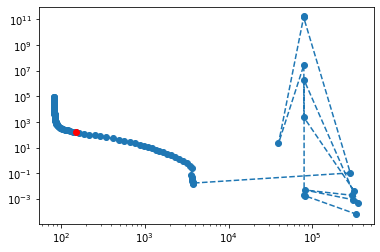

In [15]:
idx = 50
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

(0.0001, 1000.0)

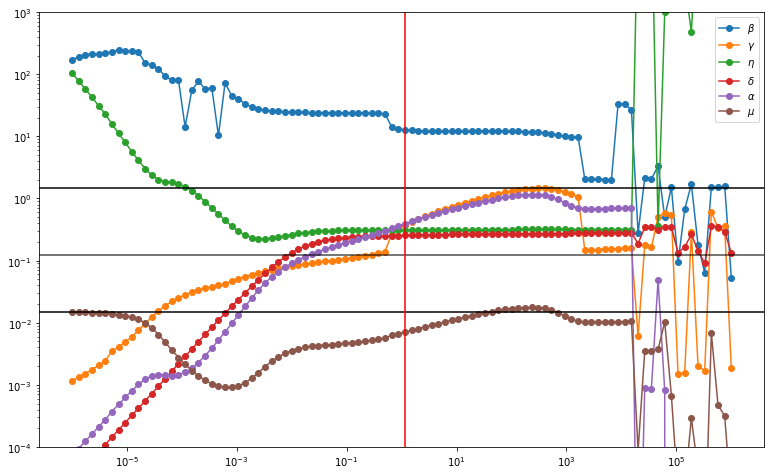

In [16]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-6]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-5]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-4]) for s in sols], 'o-', label=r'$\eta$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\delta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\mu$')
for q in p0:
    plt.axhline(q, color='k')
plt.axhline(0.125, color='k', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()
plt.ylim([1e-4, 1e3])

17.9884


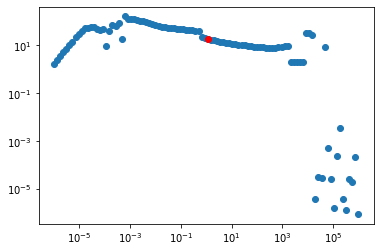

In [17]:
def r0(sol):
    b, g, e, d, a, m = getp(sol['x'])
    return b/(e+a+m)
plt.semilogx(prange, [r0(sol) for sol in sols], 'o')
plt.semilogx(prange[idx], r0(sols[idx]), 'ro')
print(r0(sols[idx]))
plt.yscale('log')

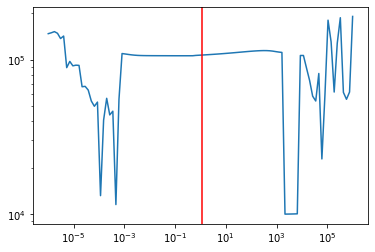

In [18]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])
plt.axvline(prange[idx], color='r')

(DM(12.7476), DM(0.370476), DM(0.306764), DM(0.254837), DM(0.394809), DM(0.0070845))


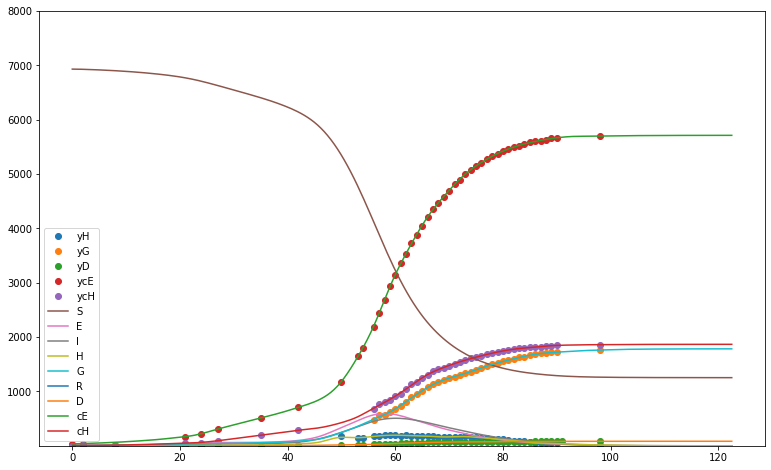

In [19]:
fig, ax=plt.subplots(figsize=[13, 8])
for data_dots in [H,G,D,cE,cH]:
    ax.plot(time, data_dots, 'o')
for data_stripe in getx(sols[idx]['x']):
    ax.plot(model.observation_times, data_stripe)
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
plt.ylim([1e-5, 8000])
print(getp(sols[idx]['x']))

In [20]:
print(list(zip("bgedam", getp(sols[idx]['x']))))

[(lbl, yyy[np.argmin(np.abs(model.observation_times-65))]) for lbl, yyy in zip('seihgrdEH', getx(sols[idx]['x'])) ]

[('b', DM(12.7476)), ('g', DM(0.370476)), ('e', DM(0.306764)), ('d', DM(0.254837)), ('a', DM(0.394809)), ('m', DM(0.0070845))]


[('s', DM(2359)),
 ('e', DM(425.801)),
 ('i', DM(441.081)),
 ('h', DM(181.138)),
 ('g', DM(1028.82)),
 ('r', DM(98586.8)),
 ('d', DM(59.5569)),
 ('E', DM(4098.12)),
 ('H', DM(1266.38))]

83.4018


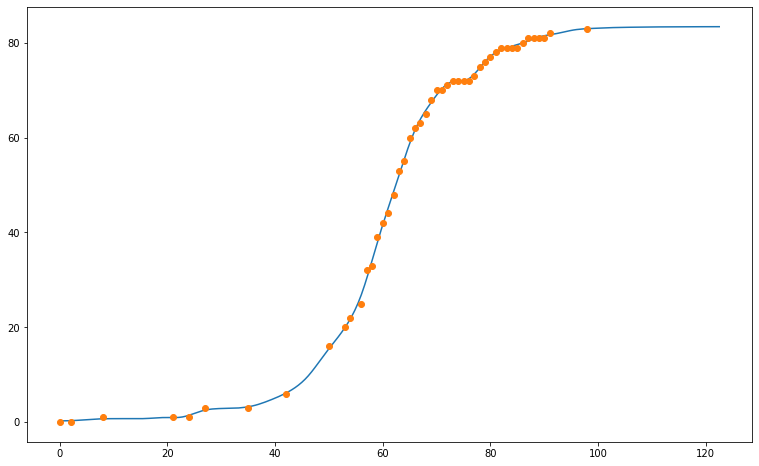

In [21]:
plt.figure(figsize=[13,8])
plt.plot(model.observation_times, getx(sols[idx]['x'])[6])
plt.plot(time, D, 'o')
print(getx(sols[idx]['x'])[6][-1])

(0, 6000)

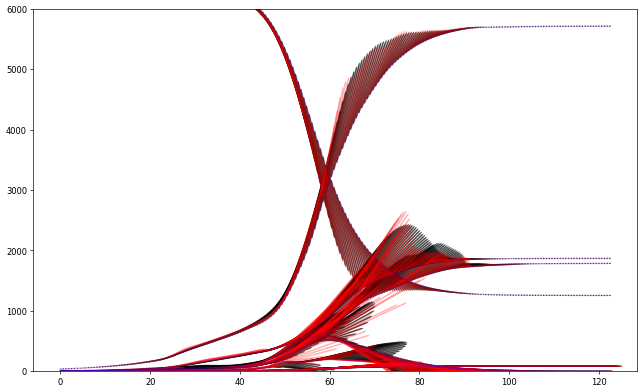

In [22]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
plt.plot(model.observation_times, xx.T, alpha=0.2, color='b')
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.7)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)
plt.ylim([0, 6000])

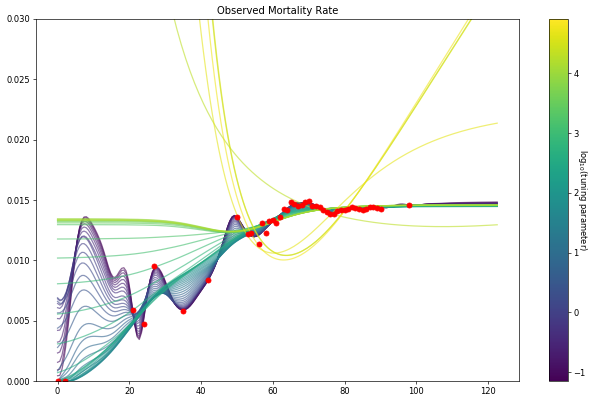

In [37]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors
i0, i1 = (40, -10)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.figure(figsize=[13,8], dpi=60)
for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[6]/getx(sols[i+i0]['x'])[-2], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.6)
plt.ylim(0, 0.03)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.title("Observed Mortality Rate")
plt.plot(time, D/cE, 'ro')

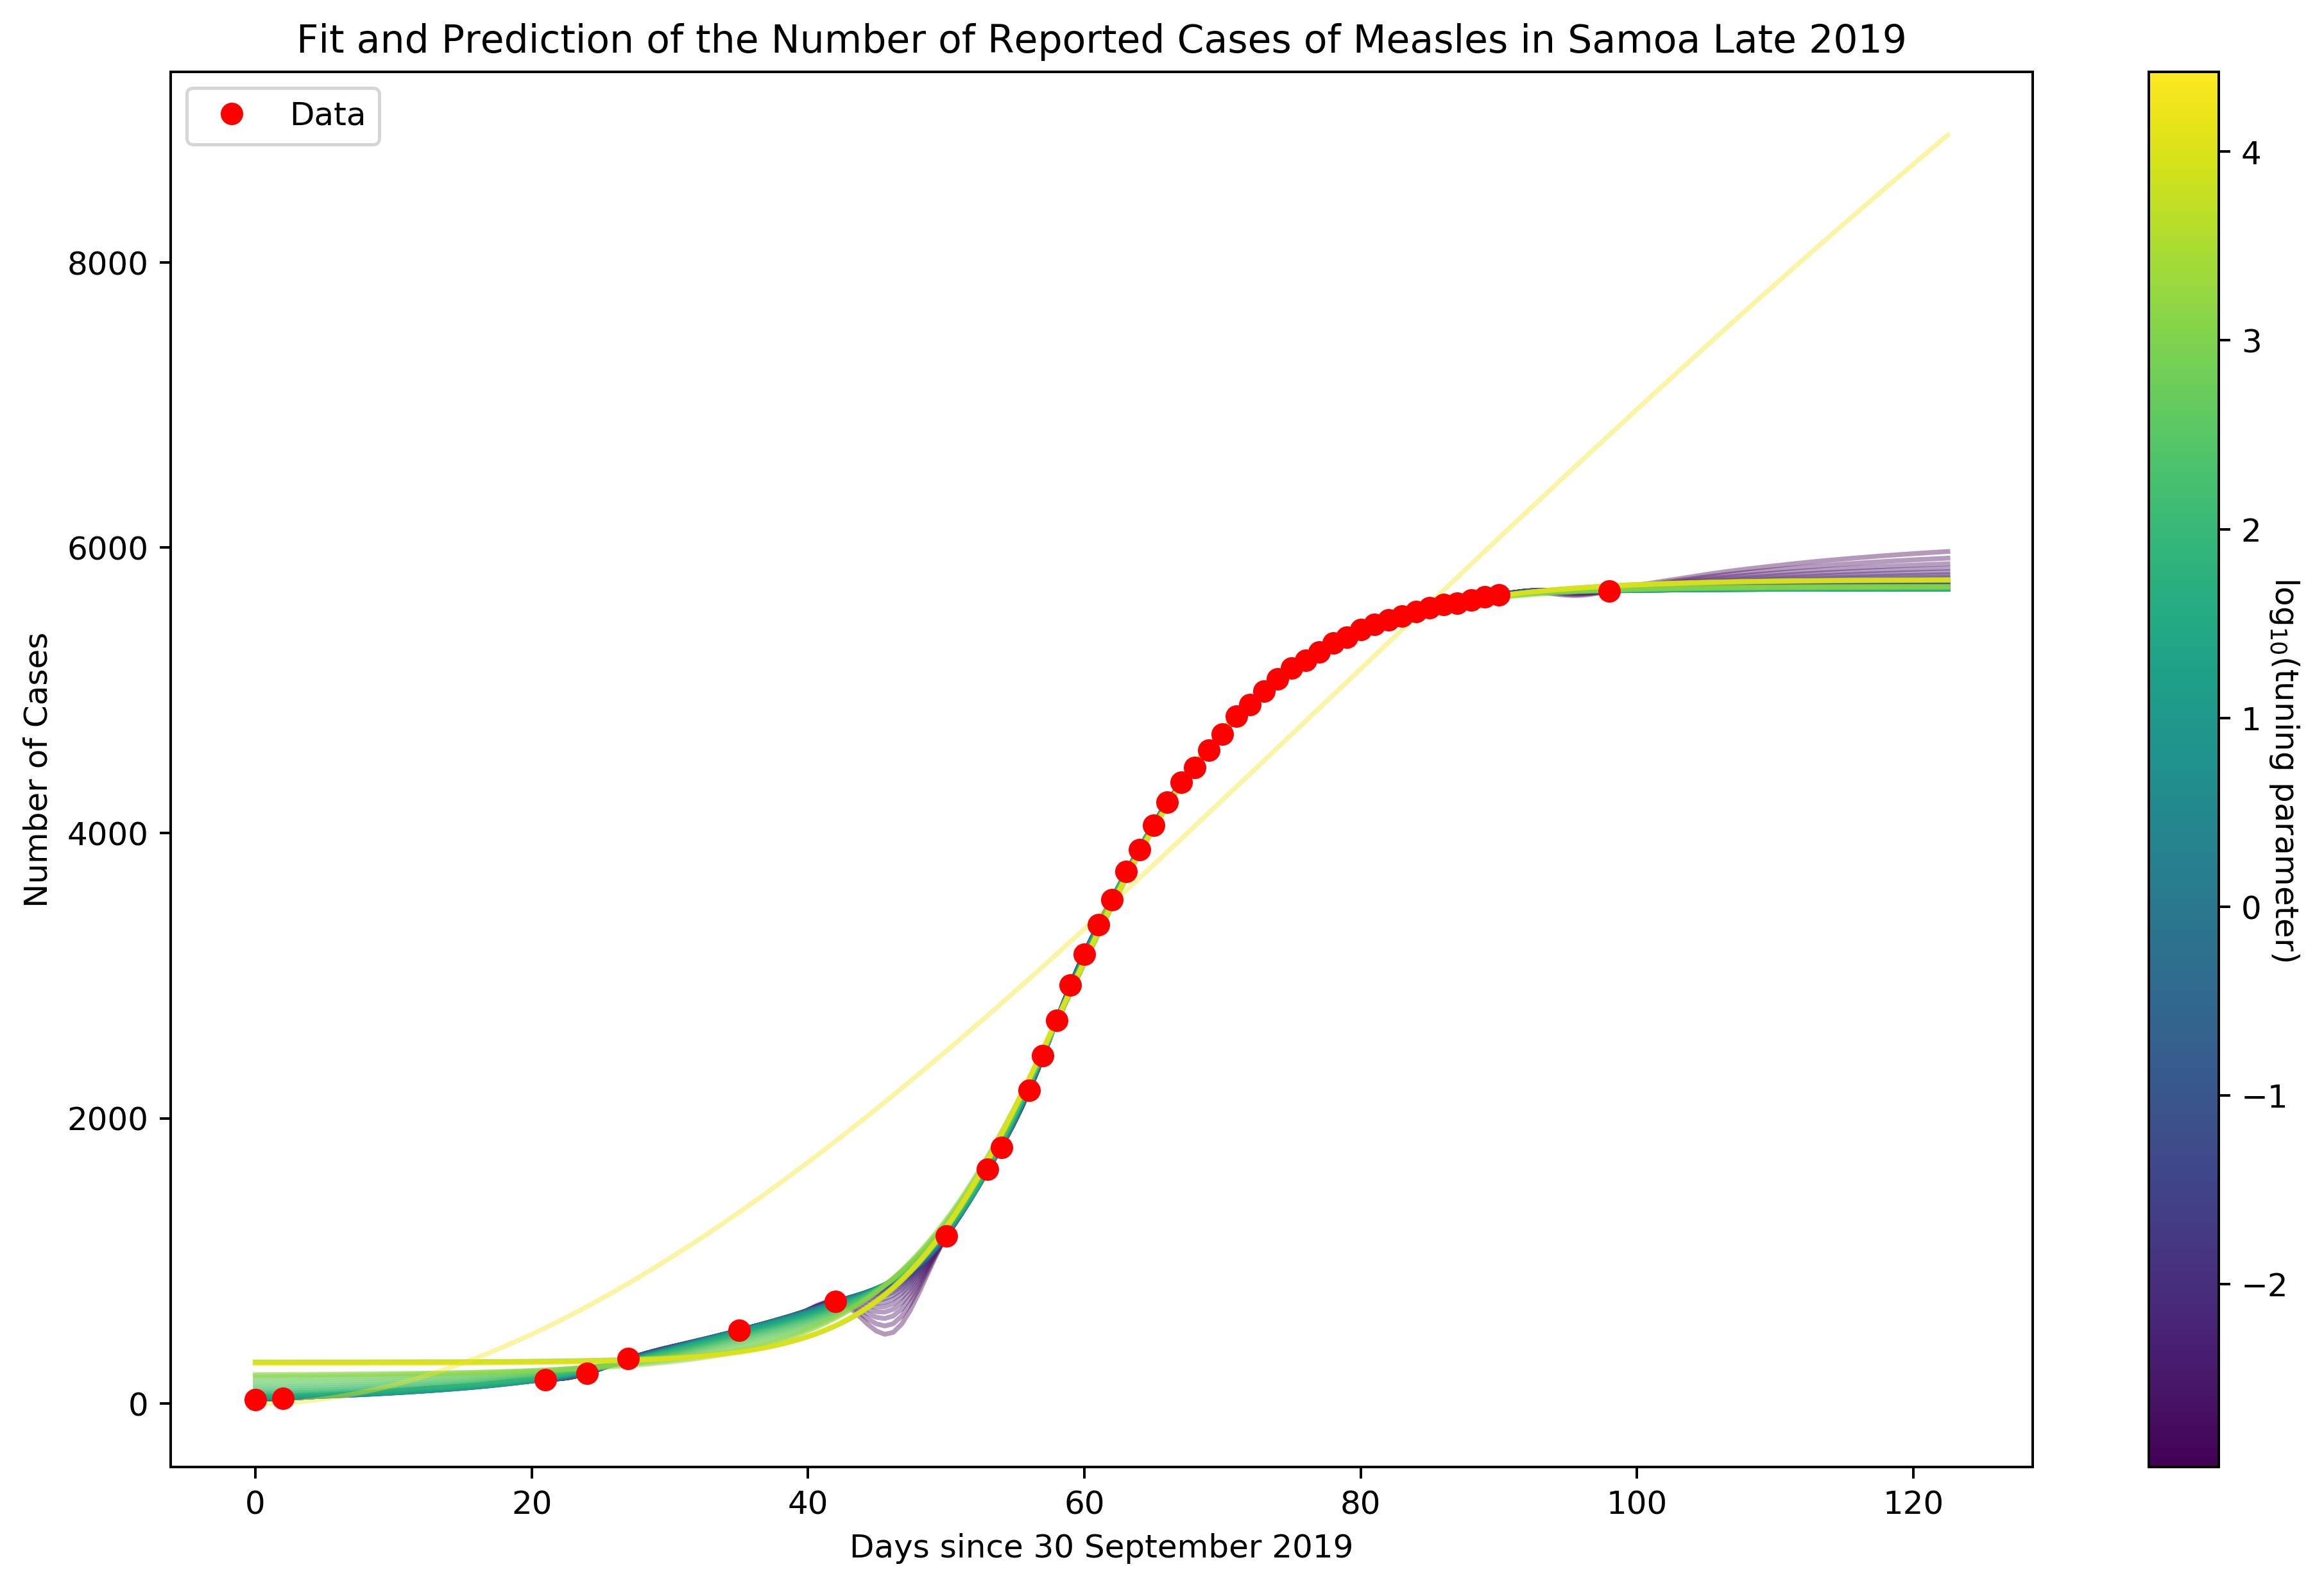

In [24]:
plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (25, -14)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[-2], color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(time, cE, 'ro', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 30 September 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()

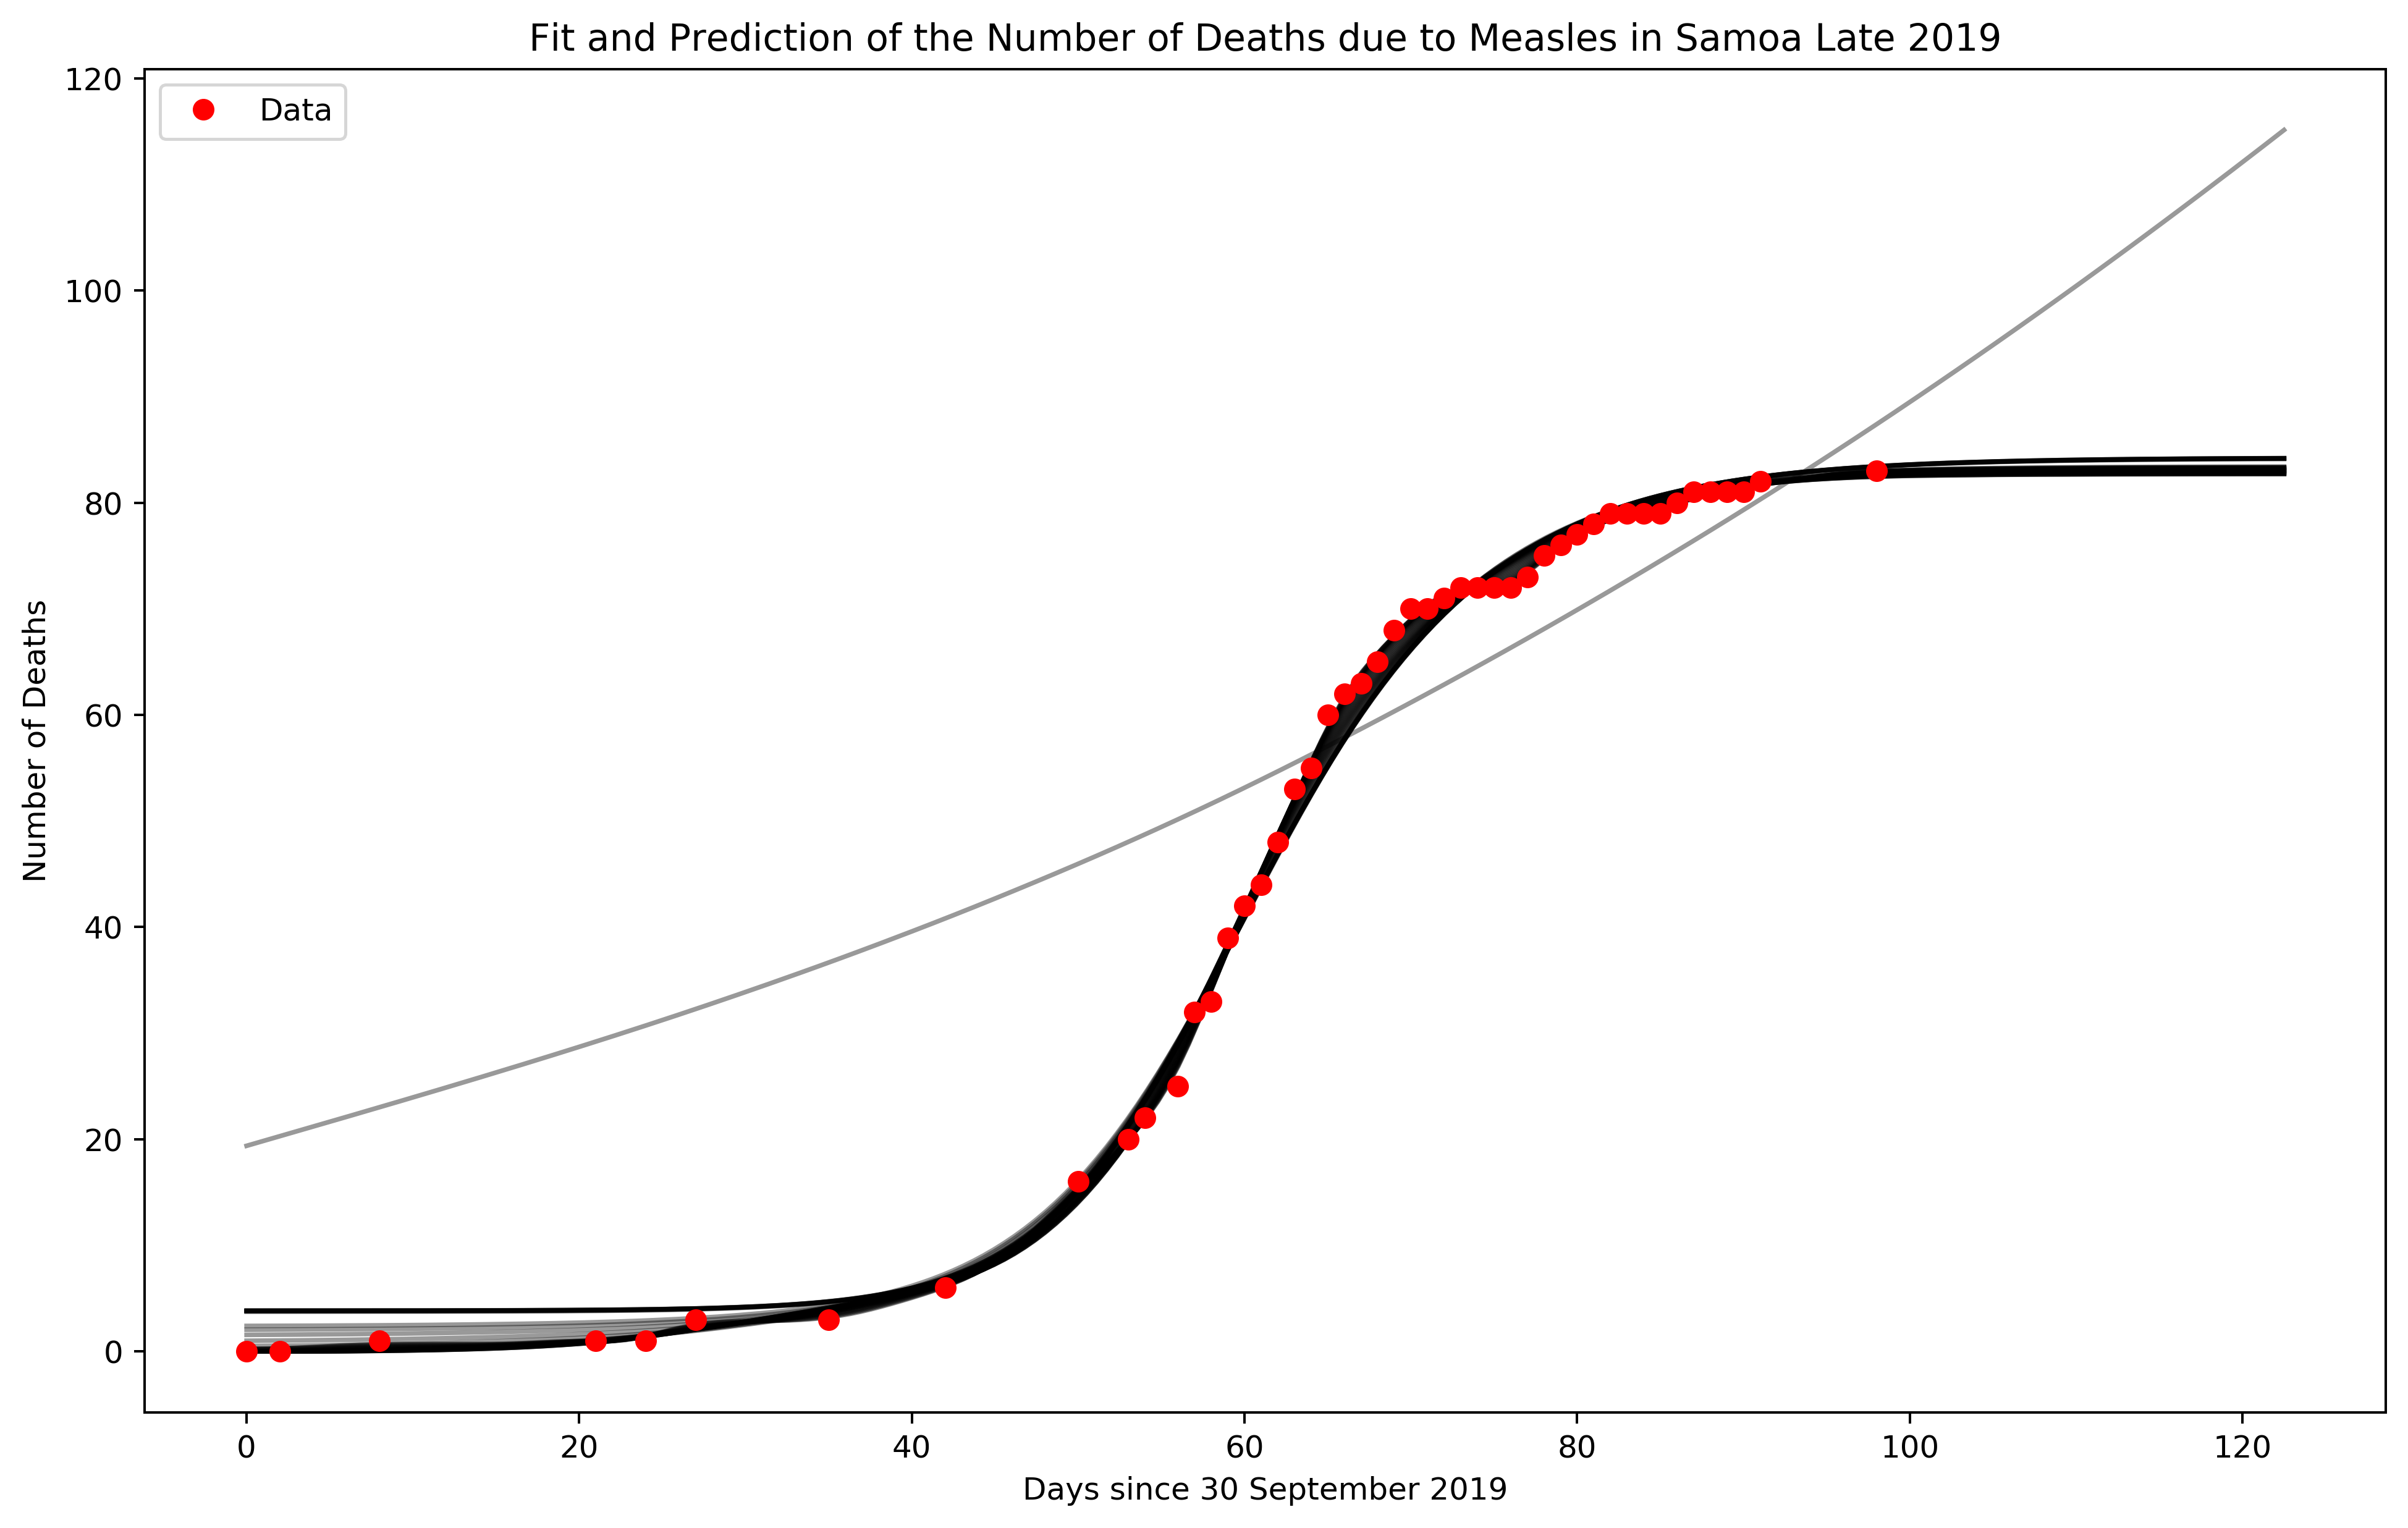

In [25]:
plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (50, -14)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[6], color='k', alpha=0.4)
plt.plot(time, D, 'ro', label="Data")
plt.title("Fit and Prediction of the Number of Deaths due to Measles in Samoa Late 2019")
plt.xlabel("Days since 30 September 2019")
plt.ylabel("Number of Deaths")
# cbar = plt.colorbar(scalarMap)
# cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()

array([5753.4419156, 5753.4419156])

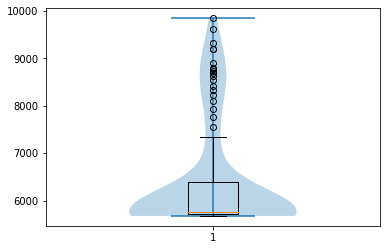

In [26]:
plt.violinplot([getx(sols[i]['x'])[-2][-1] for i in range(100)])
bx=plt.boxplot([getx(sols[i]['x'])[-2][-1] for i in range(100)])
bx['medians'][0].get_ydata()
# plt.yscale('log')

In [27]:
np.min([getx(sols[i]['x'])[-2][-1] for i in range(100)])

5675.179699652907

In [28]:
np.unique(bx['boxes'][0].get_ydata())

array([5713.98356924, 6383.01672246])

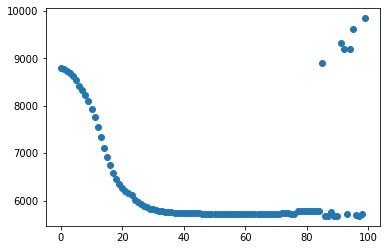

In [29]:
plt.plot([getx(sols[i]['x'])[-2][-1] for i in range(100)],'o')

(0, 100)

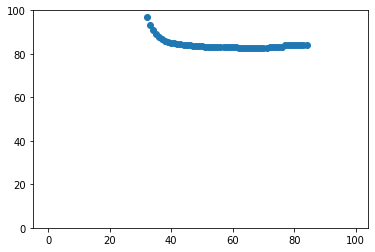

In [30]:
plt.plot([getx(sols[i]['x'])[6][-1] for i in range(100)],'o')
plt.ylim([0, 100])

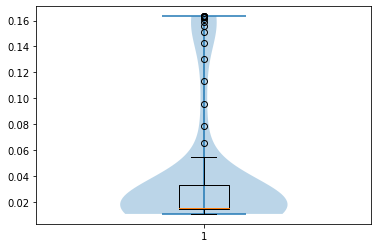

In [31]:
plt.violinplot([(getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])[-1] for i in range(100)])
bx = plt.boxplot([(getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])[-1] for i in range(100)])


In [32]:
np.unique(bx['boxes'][0].get_ydata())

array([0.01456574, 0.03326432])

In [33]:
morts = [getx(sols[i]['x'])[6][-1] for i in range(100)]
print(np.min(morts))
print(np.median(morts))

82.70068798563521
89.87729085208915


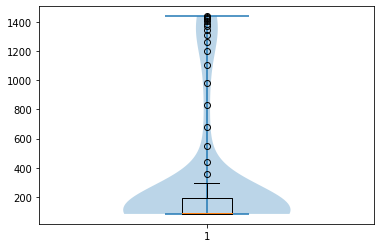

In [34]:
plt.violinplot(morts)
bx = plt.boxplot(morts)


In [35]:
np.unique(bx['boxes'][0].get_ydata())

array([ 83.35546637, 189.23384706])

In [36]:
from scipy import interpolate

print(interpolate.interp1d(model.observation_times, getx(sols[idx]['x'])[-2].toarray().flatten())(data_time[-1]+1))
print(interpolate.interp1d(model.observation_times, getx(sols[idx]['x'])[-3].toarray().flatten())(data_time[-1]+1))

5698.876725283607
83.04137993432023
